# EDA

*This notebook contains exploratory data analysis conducted on input datasets, as well as basic preprocessing including type conversion, filtering and feature selection.*

## I. Imports & functions

In [44]:
# required imports and settings
import pandas as pd
import pycountry_convert as pc
import pycountry
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [45]:
def count_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function for counting the number and percentage of missing values in each column of the data frame,
    sorting it in descending order.

    Args:
        df (pd.DataFrame): Data frame in which missing values are to be inspected.

    Returns:
        pd.DataFrame: Data frame containg missing values number and percentage for each of the columns
                        in the input data frame. 
    """
    total = df.isna().sum().sort_values(ascending=False) # how many missings in each column
    percent = (df.isna().sum()/df.isna().count()).round(4).sort_values(ascending=False) # in %
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data.rename_axis('Column').reset_index()
    return missing_data

## II. PENN World Table

In [46]:
# reading data
data_penn = pd.read_excel('data/penn/pwt100.xlsx', sheet_name='Data')
data_penn.head()

countrycode country   currency_unit  year  rgdpe  rgdpo  pop  emp  avh  hc  \
0         ABW   Aruba  Aruban Guilder  1950    NaN    NaN  NaN  NaN  NaN NaN   
1         ABW   Aruba  Aruban Guilder  1951    NaN    NaN  NaN  NaN  NaN NaN   
2         ABW   Aruba  Aruban Guilder  1952    NaN    NaN  NaN  NaN  NaN NaN   
3         ABW   Aruba  Aruban Guilder  1953    NaN    NaN  NaN  NaN  NaN NaN   
4         ABW   Aruba  Aruban Guilder  1954    NaN    NaN  NaN  NaN  NaN NaN   

   ccon  cda  cgdpe  cgdpo  cn  ck  ctfp  cwtfp  rgdpna  rconna  rdana  rnna  \
0   NaN  NaN    NaN    NaN NaN NaN   NaN    NaN     NaN     NaN    NaN   NaN   
1   NaN  NaN    NaN    NaN NaN NaN   NaN    NaN     NaN     NaN    NaN   NaN   
2   NaN  NaN    NaN    NaN NaN NaN   NaN    NaN     NaN     NaN    NaN   NaN   
3   NaN  NaN    NaN    NaN NaN NaN   NaN    NaN     NaN     NaN    NaN   NaN   
4   NaN  NaN    NaN    NaN NaN NaN   NaN    NaN     NaN     NaN    NaN   NaN   

   rkna  rtfpna  rwtfpna  labsh  irr  delta  xr  pl_con  pl_da  pl_gdpo i_cig  \
0   NaN     NaN      NaN    NaN  NaN    NaN NaN     NaN    NaN      NaN   NaN   
1   NaN     NaN      NaN    NaN  NaN    NaN NaN     NaN    NaN      NaN   NaN   
2   NaN     NaN      NaN    NaN  NaN    NaN NaN     NaN    NaN      NaN   NaN   
3   NaN     NaN      NaN    NaN  NaN    NaN NaN     NaN    NaN      NaN   NaN   
4   NaN     NaN      NaN    NaN  NaN    NaN NaN     NaN    NaN      NaN   NaN   

  i_xm i_xr i_outlier i_irr  cor_exp  statcap  csh_c  csh_i  csh_g  csh_x  \
0  NaN  NaN       NaN   NaN      NaN      NaN    NaN    NaN    NaN    NaN   
1  NaN  NaN       NaN   NaN      NaN      NaN    NaN    NaN    NaN    NaN   
2  NaN  NaN       NaN   NaN      NaN      NaN    NaN    NaN    NaN    NaN   
3  NaN  NaN       NaN   NaN      NaN      NaN    NaN    NaN    NaN    NaN   
4  NaN  NaN       NaN   NaN      NaN      NaN    NaN    NaN    NaN    NaN   

   csh_m  csh_r  pl_c  pl_i  pl_g  pl_x  pl_m  pl_n  pl_k  
0    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [47]:
# dropping column unnecessary for furter analysis
data_penn = data_penn.drop('currency_unit', axis=1)

In [48]:
# inspecting data structure
data_penn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12810 entries, 0 to 12809
Data columns (total 51 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   countrycode  12810 non-null  object 
 1   country      12810 non-null  object 
 2   year         12810 non-null  int64  
 3   rgdpe        10399 non-null  float64
 4   rgdpo        10399 non-null  float64
 5   pop          10399 non-null  float64
 6   emp          9529 non-null   float64
 7   avh          3492 non-null   float64
 8   hc           8637 non-null   float64
 9   ccon         10399 non-null  float64
 10  cda          10399 non-null  float64
 11  cgdpe        10399 non-null  float64
 12  cgdpo        10395 non-null  float64
 13  cn           10314 non-null  float64
 14  ck           7095 non-null   float64
 15  ctfp         6412 non-null   float64
 16  cwtfp        6412 non-null   float64
 17  rgdpna       10399 non-null  float64
 18  rconna       10399 non-null  float64
 19  rdan

In [49]:
# checking for duplicated rows
data_penn.duplicated().sum()

0

In [50]:
# filtering the data to leave only European countries
alpha2 = pd.DataFrame([pc.country_alpha3_to_country_alpha2(code) for code in data_penn.countrycode], columns = ['code'])
alpha2.loc[alpha2.code=="SX", 'code'] = 'MF' # assinging proper code for Saint Martin island
continents = pd.DataFrame([pc.country_alpha2_to_continent_code(code) for code in alpha2.code], columns=['continent']) 
data_penn_europe = data_penn[continents.continent == 'EU'] # filtering Europe
data_penn_europe.shape

(2730, 51)

In [51]:
print('Country names: ', sorted(data_penn_europe.country.unique()))
print('Number of countries: ', len(data_penn_europe.country.unique()))

Country names:  ['Albania', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Republic of Moldova', 'Romania', 'Russian Federation', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom']
Number of countries:  39


In [52]:
# missing values
count_missings(data_penn_europe)

Column  Total  Percent
0       statcap   2509   0.9190
1       cor_exp   2327   0.8524
2           avh   1155   0.4231
3       rwtfpna   1001   0.3667
4        rtfpna   1001   0.3667
5         cwtfp   1001   0.3667
6          ctfp   1001   0.3667
7          pl_k    923   0.3381
8            ck    923   0.3381
9          rkna    923   0.3381
10           hc    815   0.2985
11        i_irr    775   0.2839
12          irr    775   0.2839
13           cn    695   0.2546
14        cgdpo    695   0.2546
15    i_outlier    695   0.2546
16        rgdpo    695   0.2546
17        rgdpe    695   0.2546
18        csh_c    695   0.2546
19        csh_i    695   0.2546
20        csh_g    695   0.2546
21        csh_x    695   0.2546
22        csh_m    695   0.2546
23        csh_r    695   0.2546
24         pl_c    695   0.2546
25         pl_i    695   0.2546
26         pl_g    695   0.2546
27         pl_x    695   0.2546
28         pl_m    695   0.2546
29         pl_n    695   0.2546
30         i_xr    695   0.2546
31         i_xm    695   0.2546
32        i_cig    695   0.2546
33          emp    695   0.2546
34        cgdpe    695   0.2546
35          cda    695   0.2546
36       rgdpna    695   0.2546
37       rconna    695   0.2546
38        rdana    695   0.2546
39         rnna    695   0.2546
40         ccon    695   0.2546
41          pop    695   0.2546
42      pl_gdpo    695   0.2546
43        delta    695   0.2546
44           xr    695   0.2546
45       pl_con    695   0.2546
46        pl_da    695   0.2546
47        labsh    495   0.1813
48      country      0   0.0000
49         year      0   0.0000
50  countrycode      0   0.0000

In [53]:
# missing values for the data from 1990 till now
count_missings(data_penn_europe[data_penn_europe['year'] >= 1990])

Column  Total  Percent
0       statcap    949   0.8111
1       cor_exp    823   0.7034
2           avh    289   0.2470
3       rwtfpna    194   0.1658
4        rtfpna    194   0.1658
5         cwtfp    194   0.1658
6          ctfp    194   0.1658
7            hc    120   0.1026
8          pl_k    116   0.0991
9            ck    116   0.0991
10         rkna    116   0.0991
11        i_irr     60   0.0513
12        labsh     60   0.0513
13          irr     60   0.0513
14           cn      0   0.0000
15         i_xr      0   0.0000
16        rgdpo      0   0.0000
17        rgdpe      0   0.0000
18         year      0   0.0000
19        csh_c      0   0.0000
20        csh_i      0   0.0000
21        csh_g      0   0.0000
22        csh_x      0   0.0000
23        csh_m      0   0.0000
24        csh_r      0   0.0000
25         pl_c      0   0.0000
26         pl_i      0   0.0000
27         pl_g      0   0.0000
28         pl_x      0   0.0000
29         pl_m      0   0.0000
30         pl_n      0   0.0000
31    i_outlier      0   0.0000
32         i_xm      0   0.0000
33        cgdpo      0   0.0000
34        i_cig      0   0.0000
35        cgdpe      0   0.0000
36       rgdpna      0   0.0000
37       rconna      0   0.0000
38        rdana      0   0.0000
39         rnna      0   0.0000
40          cda      0   0.0000
41         ccon      0   0.0000
42          emp      0   0.0000
43          pop      0   0.0000
44      country      0   0.0000
45        delta      0   0.0000
46           xr      0   0.0000
47       pl_con      0   0.0000
48        pl_da      0   0.0000
49      pl_gdpo      0   0.0000
50  countrycode      0   0.0000

In [54]:
# selecting one random indicator
data_test = data_penn_europe[['country', 'year', 'rgdpe']]
# transposing subset of the data
data_test_t = data_test.set_index(['country', 'year']).rgdpe.unstack().reset_index()
data_test_t.head()

year                 country          1950          1951          1952  \
0                    Albania           NaN           NaN           NaN   
1                    Austria  40357.289062  41846.480469  43857.648438   
2                    Belarus           NaN           NaN           NaN   
3                    Belgium  75285.921875  80468.148438  82140.664062   
4     Bosnia and Herzegovina           NaN           NaN           NaN   

year          1953          1954          1955          1956          1957  \
0              NaN           NaN           NaN           NaN           NaN   
1     46026.796875  49078.171875  53920.039062  58295.656250  61308.078125   
2              NaN           NaN           NaN           NaN           NaN   
3     82216.664062  85718.101562  91011.148438  95059.851562  95819.382812   
4              NaN           NaN           NaN           NaN           NaN   

year          1958          1959           1960           1961           1962  \
0              NaN           NaN            NaN            NaN            NaN   
1     64191.605469  66691.546875   71715.843750   75887.781250   78181.000000   
2              NaN           NaN            NaN            NaN            NaN   
3     95461.320312  96738.421875  102919.179688  107518.242188  113236.976562   
4              NaN           NaN            NaN            NaN            NaN   

year           1963           1964           1965           1966  \
0               NaN            NaN            NaN            NaN   
1      81741.117188   85801.515625   88744.039062   93206.437500   
2               NaN            NaN            NaN            NaN   
3     117017.281250  125598.664062  130886.476562  135008.984375   
4               NaN            NaN            NaN            NaN   

year           1967           1968        1969           1970           1971  \
0               NaN            NaN         NaN    6681.828613    6950.334473   
1      96198.335938  100632.609375  105549.250  111881.242188  117554.250000   
2               NaN            NaN         NaN            NaN            NaN   
3     140139.343750  145929.000000  156273.375  165948.406250  171450.312500   
4               NaN            NaN         NaN            NaN            NaN   

year           1972           1973           1974           1975  \
0       7230.394043    7518.899414    7821.087891    8136.811035   
1     125129.015625  132343.171875  135241.546875  136149.093750   
2               NaN            NaN            NaN            NaN   
3     182810.140625  196870.640625  203615.062500  199590.859375   
4               NaN            NaN            NaN            NaN   

year           1976           1977           1978           1979  \
0       8450.694336    8808.267578    9165.297852    9463.035156   
1     140292.921875  146131.718750  146276.593750  152109.843750   
2               NaN            NaN            NaN            NaN   
3     212703.640625  217205.687500  225729.562500  233885.390625   
4               NaN            NaN            NaN            NaN   

year           1980           1981           1982           1983  \
0       9974.774414   10320.928711   10414.697266   10800.652344   
1     152980.468750  151429.250000  152637.453125  156059.296875   
2               NaN            NaN            NaN            NaN   
3     243294.281250  227759.593750  220415.531250  213840.453125   
4               NaN            NaN            NaN            NaN   

year           1984           1985           1986           1987  \
0      10967.807617   11049.231445   11681.791016   11882.933594   
1     155888.796875  158950.500000  166557.203125  173385.218750   
2               NaN            NaN            NaN            NaN   
3     214285.140625  212411.203125  223275.234375  231404.734375   
4               NaN            NaN            NaN            NaN   

year           1988           1989           1990           1991  \
0    

<AxesSubplot:>

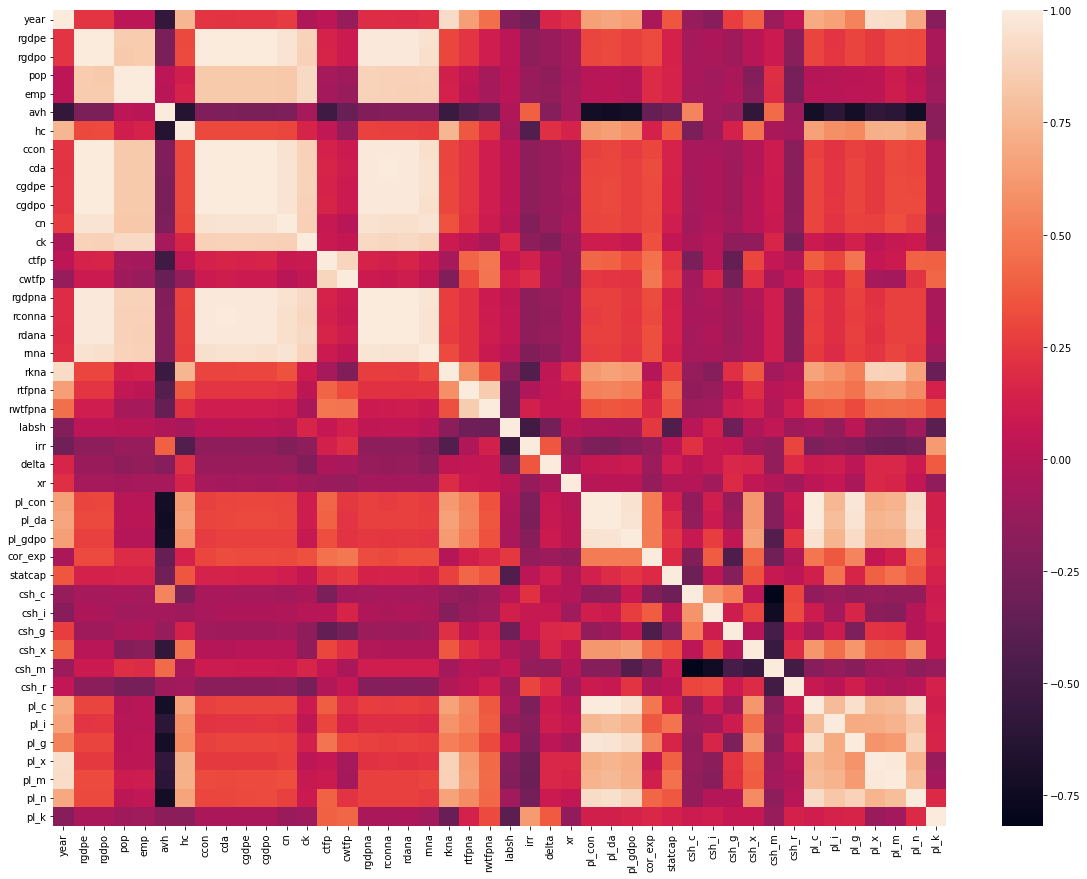

In [55]:
# Pearson's correlations (heatmap)
plt.figure(figsize=(20,15))
cor = data_penn_europe.corr()
sns.heatmap(cor)

In [56]:
# dropping columns due to different reasons
data_penn_europe = data_penn_europe.drop([
                  'ck','ctfp','cwtfp', 'rkna','rtfpna','rwtfpna', # relative variables
                  'pl_con','pl_da','pl_gdpo', # relative variables
                  'i_cig','i_xm','i_xr','i_outlier','i_irr', # information variables
                  'cor_exp','statcap', # very high percentage of missing data
                  'pl_c','pl_i','pl_g','pl_x','pl_m','pl_n','pl_k' # relative variables
                 ], axis=1)
data_penn_europe.shape

(2730, 28)

In [57]:
# missing values (after deletion)
count_missings(data_penn_europe)

Column  Total  Percent
0           avh   1155   0.4231
1            hc    815   0.2985
2           irr    775   0.2839
3        rgdpna    695   0.2546
4        rconna    695   0.2546
5         csh_m    695   0.2546
6         csh_x    695   0.2546
7         csh_g    695   0.2546
8         csh_i    695   0.2546
9         csh_c    695   0.2546
10           xr    695   0.2546
11        delta    695   0.2546
12         rnna    695   0.2546
13        rdana    695   0.2546
14        csh_r    695   0.2546
15           cn    695   0.2546
16        cgdpo    695   0.2546
17        cgdpe    695   0.2546
18          cda    695   0.2546
19         ccon    695   0.2546
20          emp    695   0.2546
21          pop    695   0.2546
22        rgdpo    695   0.2546
23        rgdpe    695   0.2546
24        labsh    495   0.1813
25      country      0   0.0000
26         year      0   0.0000
27  countrycode      0   0.0000

In [58]:
# count of missing values for each country, for each variable
data_penn_europe.drop('country', axis=1).isna().groupby(data_penn_europe.country, sort=False).sum().reset_index()

country  countrycode  year  rgdpe  rgdpo  pop  emp  avh  \
0                  Albania            0     0     20     20   20   20   70   
1                  Austria            0     0      0      0    0    0    0   
2                  Belgium            0     0      0      0    0    0    0   
3                 Bulgaria            0     0     20     20   20   20   45   
4   Bosnia and Herzegovina            0     0     40     40   40   40   70   
5                  Belarus            0     0     40     40   40   40   70   
6              Switzerland            0     0      0      0    0    0    0   
7           Czech Republic            0     0     40     40   40   40   43   
8                  Germany            0     0      0      0    0    0    0   
9                  Denmark            0     0      0      0    0    0    0   
10                   Spain            0     0      0      0    0    0    0   
11                 Estonia            0     0     40     40   40   40   45   
12                 Finland            0     0      0      0    0    0    0   
13                  France            0     0      0      0    0    0    0   
14          United Kingdom            0     0      0      0    0    0    0   
15                  Greece            0     0      1      1    1    1    1   
16                 Croatia            0     0     40     40   40   40   45   
17                 Hungary            0     0     20     20   20   20   30   
18                 Ireland            0     0      0      0    0    0    0   
19                 Iceland            0     0      0      0    0    0   14   
20                   Italy            0     0      0      0    0    0    0   
21               Lithuania            0     0     40     40   40   40   45   
22              Luxembourg            0     0      0      0    0    0   20   
23                  Latvia            0     0     40     40   40   40   45   
24     Republic of Moldova            0     0     40     40   40   40   70   
25         North Macedonia            0     0     40     40   40   40   70   
26                   Malta            0     0      4      4    4    4   44   
27              Montenegro            0     0     40     40   40   40   70   
28             Netherlands            0     0      0      0    0    0    1   
29                  Norway            0     0      0      0    0    0    0   
30                  Poland            0     0     20     20   20   20   45   
31                Portugal            0     0      0      0    0    0    0   
32                 Romania            0     0     10     10   10   10   45   
33      Russian Federation            0     0     40     40   40   40   42   
34                  Serbia            0     0     40     40   40   40   70   
35                Slovakia            0     0     40     40   40   40   40   
36                Slovenia            0     0     40     40   40   40   45   
37                  Sweden            0     0      0      0    0    0    0   
38                 Ukraine            0     0     40     40   40   40   70   

    hc  ccon  cda  cgdpe  cgdpo  cn  rgdpna  rconna  rdana  rnna  labsh  irr  \
0   20    20   20     20     20  20      20      20     20    20     70   70   
1    0     0    0      0      0   0       0       0      0     0      0    0   
2    0     0    0      0      0   0       0       0      0     0      0    0   
3   20    20   20     20     20  20      20      20     20    20     20   20   
4   70    40   40     40     40  40      40      40     40    40     20   40   
5   70    40   40     40     40  40      40      40     40    40     20   40   
6    0     0    0      0      0   0       0       0      0     0      0    0   
7   40    40   40     40     40  40      40      40     40    40     20   40   
8    0     0    0      0      0   0       0       0      0     0      0    0   
9    0     0    0      0      0   0       0       0      0     0      0    0   
10   0     0    0 

<AxesSubplot:>

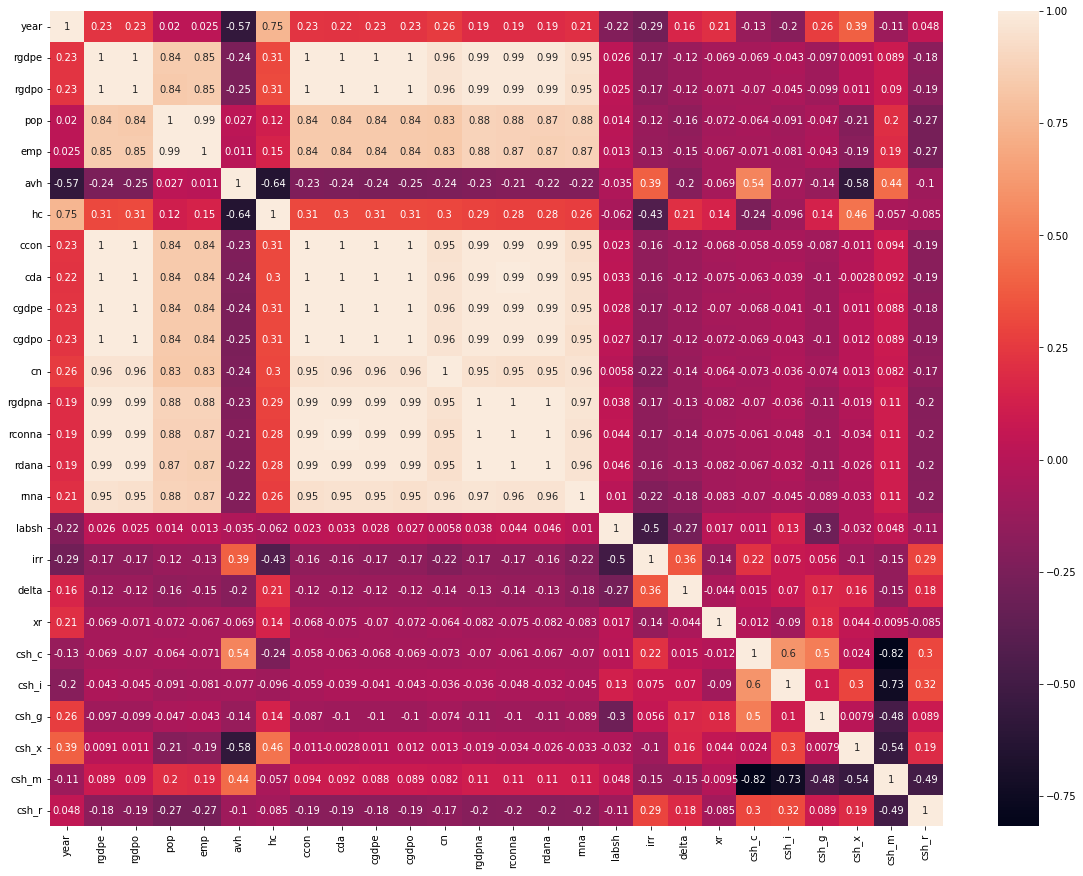

In [59]:
# Pearson's correlations (after deletion)
plt.figure(figsize=(20,15))
cor = data_penn_europe.corr()
sns.heatmap(cor, annot=True)

In [60]:
# dropping columns due to different reasons
data_penn_europe = data_penn_europe.drop(['ccon', 'cda', 'cn', # unnecessary variables
        'rgdpe', 'rgdpo', 'cgdpe', 'cgdpo', # other forms of GDP (one left)
        'rconna', 'rdana', 'rnna'], axis = 1) # high correlation  

In [61]:
# adding gdp per capita = rgdpna (GDP) / pop (population)
data_penn_europe['rgdpna_per_cap'] = data_penn_europe['rgdpna'] / data_penn_europe['pop']
# adding percent of population working
data_penn_europe['emp_percent'] = data_penn_europe['emp'] / data_penn_europe['pop'] * 100

<AxesSubplot:>

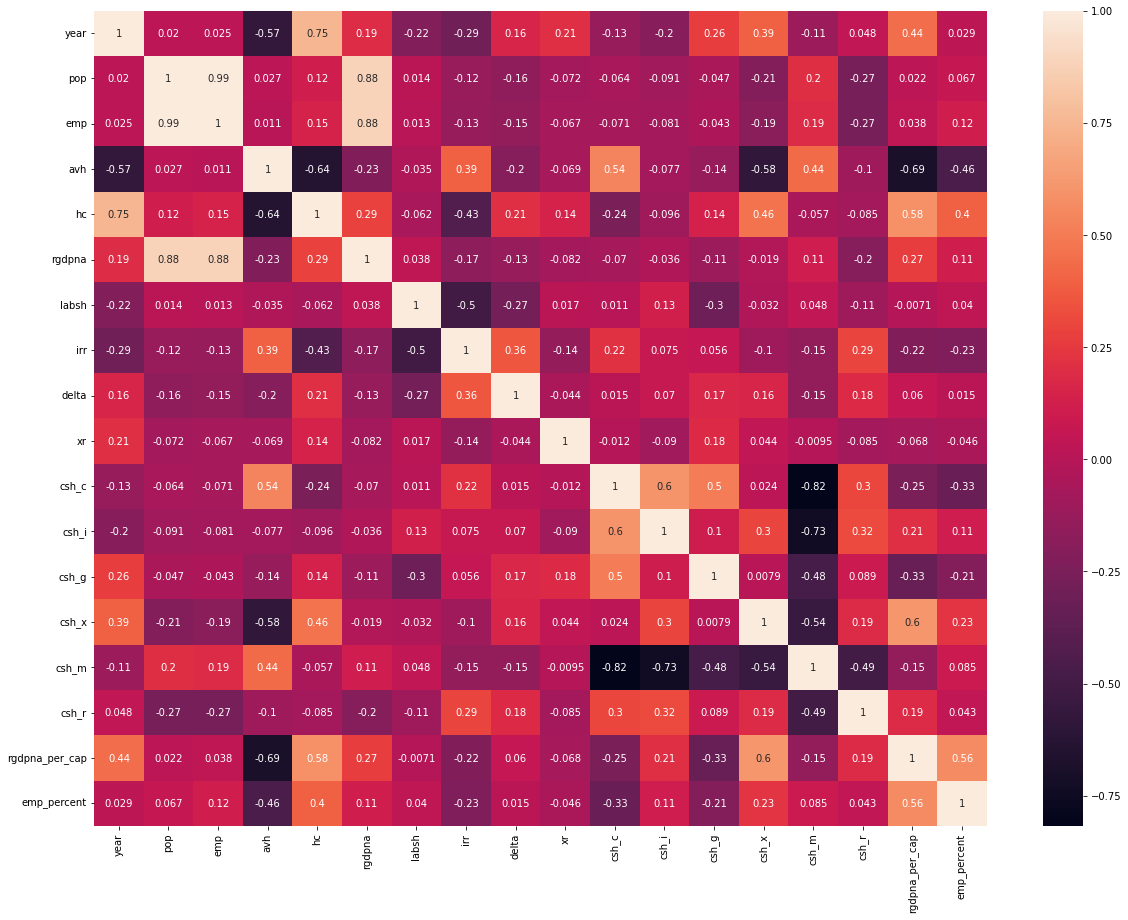

In [62]:
# Pearson's correlation (after deletion, adding columns)
plt.figure(figsize=(20,15))
cor = data_penn_europe.corr()
sns.heatmap(cor, annot=True)

In [63]:
# missing values for the data from 1990 till now
miss_df = count_missings(data_penn_europe[data_penn_europe['year'] >= 1990])
miss_df[miss_df.Percent>0] # filtering only the columns with any missing values

Column  Total  Percent
0    avh    289   0.2470
1     hc    120   0.1026
2  labsh     60   0.0513
3    irr     60   0.0513

In [64]:
# statistics
data_penn_europe.describe()

year          pop          emp          avh           hc  \
count  2730.000000  2035.000000  2035.000000  1575.000000  1915.000000   
mean   1984.500000    18.476112     8.194387  1828.680053     2.798519   
std      20.208899    26.059374    12.050175   227.289576     0.511580   
min    1950.000000     0.143164     0.065468  1380.607643     1.241877   
25%    1967.000000     3.701465     1.403216  1656.117357     2.487825   
50%    1984.500000     8.053002     3.490451  1827.734313     2.847474   
75%    2002.000000    19.725127     9.287050  1987.153428     3.167833   
max    2019.000000   148.373580    75.279228  2428.279448     3.849036   

             rgdpna        labsh          irr        delta            xr  \
count  2.035000e+03  2235.000000  1955.000000  2035.000000  2.035000e+03   
mean   4.724998e+05     0.592462     0.084036     0.037650  1.040084e+01   
std    7.692721e+05     0.077423     0.049893     0.009818  3.188239e+01   
min    6.695916e+02     0.316836     0.010000     0.020717  3.857142e-12   
25%    5.064288e+04     0.537072     0.052773     0.032006  7.193553e-01   
50%    1.798937e+05     0.594380     0.070163     0.035967  9.117255e-01   
75%    4.314496e+05     0.642973     0.101303     0.040798  5.000000e+00   
max    4.314068e+06     0.864418     0.327248     0.094306  2.906600e+02   

             csh_c        csh_i        csh_g        csh_x        csh_m  \
count  2035.000000  2035.000000  2035.000000  2035.000000  2035.000000   
mean      0.604290     0.257389     0.199686     0.311622    -0.408316   
std       0.293025     0.109300     0.088420     0.232879     0.531818   
min       0.214789     0.004488     0.044929     0.002292   -17.068502   
25%       0.528711     0.205081     0.148911     0.136595    -0.499294   
50%       0.579292     0.256618     0.182277     0.244520    -0.332234   
75%       0.644819     0.298215     0.245414     0.448582    -0.188416   
max      10.526269     3.165007     2.111259     1.693886    -0.001920   

              csh_r  rgdpna_per_cap  emp_percent  
count  2.035000e+03     2035.000000  2035.000000  
mean   3.532873e-02    25063.640309    43.658846  
std    8.686277e-02    16270.967382     7.330805  
min   -2.321352e-01     1727.772878     4.323280  
25%   -1.379044e-07    12693.273631    39.615685  
50%    1.824851e-02    21554.448164    43.919549  
75%    4.174024e-02    33235.261834    48.562496  
max    5.720825e-01    96812.317524    74.815843

## III. HDI

In [65]:
# reading data (http://hdr.undp.org/en/indicators/137506)
hdi = pd.read_csv('data/other/Human_Development_Index.csv', skiprows=5, encoding = 'cp1252')
hdi.head()

HDI Rank       Country   1990  Unnamed: 3   1991  Unnamed: 5   1992  \
0      169   Afghanistan  0.302         NaN  0.307         NaN  0.316   
1       69       Albania  0.650         NaN  0.631         NaN  0.615   
2       91       Algeria  0.572         NaN  0.576         NaN  0.582   
3       36       Andorra     ..         NaN     ..         NaN     ..   
4      148        Angola     ..         NaN     ..         NaN     ..   

   Unnamed: 7   1993  Unnamed: 9   1994  Unnamed: 11   1995  Unnamed: 13  \
0         NaN  0.312         NaN  0.307          NaN  0.331          NaN   
1         NaN  0.618         NaN  0.624          NaN  0.637          NaN   
2         NaN  0.586         NaN  0.590          NaN  0.595          NaN   
3         NaN     ..         NaN     ..          NaN     ..          NaN   
4         NaN     ..         NaN     ..          NaN     ..          NaN   

    1996  Unnamed: 15   1997  Unnamed: 17   1998  Unnamed: 19   1999  \
0  0.335          NaN  0.339          NaN  0.344          NaN  0.348   
1  0.646          NaN  0.645          NaN  0.655          NaN  0.665   
2  0.602          NaN  0.611          NaN  0.621          NaN  0.629   
3     ..          NaN     ..          NaN     ..          NaN     ..   
4     ..          NaN     ..          NaN     ..          NaN  0.391   

   Unnamed: 21   2000  Unnamed: 23   2001  Unnamed: 25   2002  Unnamed: 27  \
0          NaN  0.350          NaN  0.353          NaN  0.384          NaN   
1          NaN  0.671          NaN  0.678          NaN  0.684          NaN   
2          NaN  0.637          NaN  0.647          NaN  0.657          NaN   
3          NaN  0.813          NaN  0.815          NaN  0.820          NaN   
4          NaN  0.400          NaN  0.410          NaN  0.426          NaN   

    2003  Unnamed: 29   2004  Unnamed: 31   2005  Unnamed: 33   2006  \
0  0.393          NaN  0.409          NaN  0.418          NaN  0.429   
1  0.691          NaN  0.696          NaN  0.706          NaN  0.713   
2  0.667          NaN  0.677          NaN  0.685          NaN  0.690   
3  0.827          NaN  0.833          NaN  0.827          NaN  0.837   
4  0.435          NaN  0.446          NaN  0.460          NaN  0.473   

   Unnamed: 35   2007  Unnamed: 37   2008  Unnamed: 39   2009  Unnamed: 41  \
0          NaN  0.447          NaN  0.447          NaN  0.460          NaN   
1          NaN  0.722          NaN  0.728          NaN  0.733          NaN   
2          NaN  0.700          NaN  0.702          NaN  0.711          NaN   
3          NaN  0.837          NaN  0.840          NaN  0.839          NaN   
4          NaN  0.489          NaN  0.501          NaN  0.515          NaN   

    2010  Unnamed: 43   2011  Unnamed: 45   2012  Unnamed: 47   2013  \
0  0.472          NaN  0.477          NaN  0.489          NaN  0.496   
1  0.745          NaN  0.764          NaN  0.775          NaN  0.782   
2  0.721          NaN  0.728          NaN  0.728          NaN  0.729   
3  0.837          NaN  0.836          NaN  0.858          NaN  0.856   
4  0.517          NaN  0.533          NaN  0.544          NaN  0.555   

   Unnamed: 49   2014  Unnamed: 51   2015  Unnamed: 53   2016  Unnamed: 55  \
0          NaN  0.500          NaN  0.500          NaN  0.502          NaN   
1          NaN  0.787          NaN  0.788          NaN  0.788          NaN   
2          NaN  0.736          NaN  0.740          NaN  0.743          NaN   
3          NaN  0.863          NaN  0.862          NaN  0.866          NaN   
4          NaN  0.565          NaN  0.572          NaN  0.578          NaN   

    2017  Unnamed: 57   2018  Unnamed: 59   2019  Unnamed: 61  
0  0.506          NaN  0.509          NaN  0.511          NaN  
1  0.790          NaN  0.792          NaN  0.795          NaN  
2  0.745          NaN  0.746          NaN  0.748          NaN  
3  0.863          NaN  0.867          NaN  0.868          NaN  
4  0.582          NaN  0.582          NaN  0.581          NaN

In [66]:
# dropping unnecessary empty columns & NaNs in HDI rank
hdi = hdi.dropna(how='all', axis='columns').dropna(how='all', axis='rows').dropna(subset=['HDI Rank'], axis=0)
hdi.Country = hdi.Country.str.strip() # removing unnecessary space
hdi['Country'] = hdi['Country'].str.split(' \(').str[0] # brackets
hdi = hdi[hdi['HDI Rank'] != ' '] # regions
hdi.loc[hdi.Country=='Hong Kong, China', 'Country'] = 'Hong Kong' # changing wrong names of countries
hdi = hdi[hdi.Country != 'Korea'].reset_index(drop=True)
hdi = hdi.drop(['HDI Rank'], axis=1)
hdi = hdi.replace('..', np.NaN) # missing values

In [67]:
# assigning country codes
alpha3 = pd.DataFrame([pc.country_name_to_country_alpha3(country) for country in hdi.Country], columns = ['Code'])
hdi['countrycode'] = alpha3

In [68]:
# filtering the data to leave only European countries
alpha2 = pd.DataFrame([pc.country_alpha3_to_country_alpha2(code) for code in hdi.countrycode], columns = ['Code'])
alpha2.loc[alpha2.Code=='TL', 'Code'] = 'ID' # changing Timor to Indonesia, to be deleted anyway
continents = pd.DataFrame([pc.country_alpha2_to_continent_code(code) for code in alpha2.Code], columns=['continent'])
hdi_europe = hdi[continents.continent == 'EU'].reset_index(drop=True) # filtering Europe

hdi_europe.drop(['Country'], axis = 1, inplace = True)
hdi_europe = hdi_europe.melt(id_vars='countrycode', var_name='year', value_name='hdi') # transposition
hdi_europe = hdi_europe.astype({'year':'int64'}) # type conversion

In [69]:
# missing values
temp = hdi_europe.drop('countrycode', 1).isna().groupby(hdi_europe.countrycode, sort=False).sum().reset_index()
temp[temp.hdi>0].drop('year', axis=1)

C:\Users\agama\AppData\Local\Temp/ipykernel_28800/4059990289.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  temp = hdi_europe.drop('countrycode', 1).isna().groupby(hdi_europe.countrycode, sort=False).sum().reset_index()


countrycode  hdi
1          AND   10
3          BLR    5
5          BIH   10
20         LIE   10
25         MNE   16
27         MKD   10

## IV. World Bank

In [70]:
# list of all proper countries (in order to filter out regions etc.)
list_of_countries = []
for x in pycountry.countries:
    list_of_countries.append(x.alpha_3)

In [71]:
data_worldbank = pd.DataFrame(columns=['Country Code', 'year']) # creating empty dataframe for final data
# iterate through all the worldbank tables
for filename in os.listdir("data/worldbank/"):
    var_worldbank = pd.read_csv('data/worldbank/'+filename, skiprows = 4)
    var_worldbank = var_worldbank.dropna(how='all', axis='columns') # skip empty columns
    var_worldbank.drop(['Country Name', 'Indicator Name', 'Indicator Code'], axis = 1, inplace=True) # drop unnecessary vars
    
    var_worldbank = var_worldbank.melt(id_vars='Country Code', var_name='year', value_name=filename.replace('.csv', ''))
    var_worldbank = var_worldbank.astype({'year':'int64'})
    # merge tables
    data_worldbank = data_worldbank.merge(var_worldbank, on=['Country Code', 'year'], how='outer') 
    # filter proper countries
    data_worldbank = data_worldbank[data_worldbank['Country Code'].isin(list_of_countries)].reset_index(drop=True)

    alpha2 = pd.DataFrame([pc.country_alpha3_to_country_alpha2(code) for code in data_worldbank['Country Code']], columns = ['Code'])
    alpha2.loc[alpha2.Code=="SX", 'Code'] = 'MF' # assinging proper code for Saint Martin island
    alpha2.loc[alpha2.Code=='TL', 'Code'] = 'ID' # changing Timor to Indonesia, to be deleted anyway
    continents = pd.DataFrame([pc.country_alpha2_to_continent_code(code) for code in alpha2.Code], columns=['continent'])
    data_worldbank_europe = data_worldbank[continents.continent == 'EU'].reset_index(drop=True)

data_worldbank.head()

Country Code  year  co2_emission  employment_agro  employment_industry  \
0          ABW  1960    204.631696              NaN                  NaN   
1          AFG  1960      0.046057              NaN                  NaN   
2          AGO  1960      0.100835              NaN                  NaN   
3          ALB  1960      1.258195              NaN                  NaN   
4          AND  1960           NaN              NaN                  NaN   

   employment_services    export    import  inflation  net_migration  \
0                  NaN       NaN       NaN        NaN            NaN   
1                  NaN  4.132233  7.024793        NaN            NaN   
2                  NaN       NaN       NaN        NaN            NaN   
3                  NaN       NaN       NaN        NaN            NaN   
4                  NaN       NaN       NaN        NaN            NaN   

   population_15_64  population_above_65  population_under_14  unemployment  \
0         53.669919             2.482891            43.847190           NaN   
1         55.060841             2.798308            42.140851           NaN   
2         54.860985             3.006948            42.132067           NaN   
3         54.433436             5.410827            40.155737           NaN   
4               NaN                  NaN                  NaN           NaN   

   urban_population  
0            50.776  
1             8.401  
2            10.435  
3            30.705  
4            58.450

In [72]:
# missing values for the data from 1990 till now
count_missings(data_worldbank_europe[data_worldbank_europe['year'] >= 1990])

Column  Total  Percent
0         net_migration   1192   0.8359
1       employment_agro    295   0.2069
2   employment_industry    295   0.2069
3   employment_services    295   0.2069
4          unemployment    256   0.1795
5                export    245   0.1718
6                import    245   0.1718
7          co2_emission    237   0.1662
8      population_15_64    217   0.1522
9   population_above_65    217   0.1522
10  population_under_14    217   0.1522
11            inflation    159   0.1115
12         Country Code      0   0.0000
13                 year      0   0.0000
14     urban_population      0   0.0000

## V. Selection

In [73]:
# renaming columns
data_worldbank_europe = data_worldbank_europe.rename({'Country Code':'countrycode'}, axis=1)
# joining all the data
data = data_penn_europe.merge(data_worldbank_europe, on = ['countrycode', 'year'], how='outer'
                                  ).merge(hdi_europe, on = ['countrycode', 'year'], how='outer')
# filtering only the data from 1990 till now
data = data[data.year >= 1990]
print(data.shape)
data.head()

(1426, 34)


countrycode  country  year       pop       emp  avh        hc  \
40         ALB  Albania  1990  3.286073  1.324078  NaN  2.516159   
41         ALB  Albania  1991  3.280395  1.317463  NaN  2.515733   
42         ALB  Albania  1992  3.245886  1.052518  NaN  2.515308   
43         ALB  Albania  1993  3.195199  0.991653  NaN  2.514883   
44         ALB  Albania  1994  3.146519  1.068879  NaN  2.514457   

          rgdpna  labsh  irr     delta         xr     csh_c     csh_i  \
40  15105.708008    NaN  NaN  0.029161   7.562970  0.856953  0.106055   
41  10875.786133    NaN  NaN  0.028644   9.913647  0.830647  0.024768   
42  10094.130859    NaN  NaN  0.027829  32.275396  1.149852  0.019641   
43  11059.070312    NaN  NaN  0.027229  71.144097  0.993673  0.054909   
44  11977.291016    NaN  NaN  0.026968  94.623333  0.859124  0.077424   

       csh_g     csh_x     csh_m     csh_r  rgdpna_per_cap  emp_percent  \
40  0.149501  0.042011 -0.039518 -0.115001     4596.887533    40.293633   
41  0.251147  0.048235 -0.098372 -0.056425     3315.389193    40.161709   
42  0.252175  0.053268 -0.242801 -0.232135     3109.822976    32.426220   
43  0.196970  0.035555 -0.172263 -0.108844     3461.152283    31.035730   
44  0.208649  0.028667 -0.111053 -0.062811     3806.521116    33.970203   

    co2_emission  employment_agro  employment_industry  employment_services  \
40      1.840841              NaN                  NaN                  NaN   
41      1.258116        57.910000                11.58            30.510000   
42      0.689859        58.110001                11.45            30.440001   
43      0.641406        57.619999                11.63            30.750000   
44      0.667179        57.080002                11.79            31.129999   

       export     import   inflation  net_migration  population_15_64  \
40  15.405064  24.031900   -0.431369            NaN         61.730339   
41   7.484819  28.585701   35.514247            NaN         61.456989   
42  12.499591  96.285881  232.984659      -443212.0         61.232496   
43  15.978830  64.539503  125.650814            NaN         61.071314   
44  11.983694  41.118890   35.842475            NaN         60.946907   

    population_above_65  population_under_14  unemployment  urban_population  \
40             5.494978            32.774683           NaN            36.428   
41             5.648771            32.894240         16.22            36.700   
42             5.827500            32.940005         16.33            37.249   
43             6.025916            32.902771         16.52            37.799   
44             6.230600            32.822494         16.57            38.354   

      hdi  
40  0.650  
41  0.631  
42  0.615  
43  0.618  
44  0.624

In [74]:
data = data.astype({'hdi':'float64'}) # type conversion
data = data.replace(':', np.NaN) # missing values

In [75]:
print('Number of countries: ', len(set(data.countrycode)))
print('Time range (years): ', len(set(data.year))) # 1990 - 2020

Number of countries:  46
Time range (years):  31


In [76]:
# missing values
count_missings(data)

Column  Total  Percent
0         net_migration   1192   0.8359
1                   avh    545   0.3822
2                    hc    376   0.2637
3                 labsh    316   0.2216
4                   irr    316   0.2216
5   employment_services    295   0.2069
6   employment_industry    295   0.2069
7       employment_agro    295   0.2069
8                   hdi    257   0.1802
9                 csh_x    256   0.1795
10         unemployment    256   0.1795
11          emp_percent    256   0.1795
12       rgdpna_per_cap    256   0.1795
13              country    256   0.1795
14                csh_m    256   0.1795
15                csh_r    256   0.1795
16                csh_g    256   0.1795
17                csh_i    256   0.1795
18                csh_c    256   0.1795
19                   xr    256   0.1795
20                  pop    256   0.1795
21                delta    256   0.1795
22               rgdpna    256   0.1795
23                  emp    256   0.1795
24               import    245   0.1718
25               export    245   0.1718
26         co2_emission    237   0.1662
27     population_15_64    217   0.1522
28  population_above_65    217   0.1522
29  population_under_14    217   0.1522
30            inflation    159   0.1115
31                 year      0   0.0000
32     urban_population      0   0.0000
33          countrycode      0   0.0000

<AxesSubplot:>

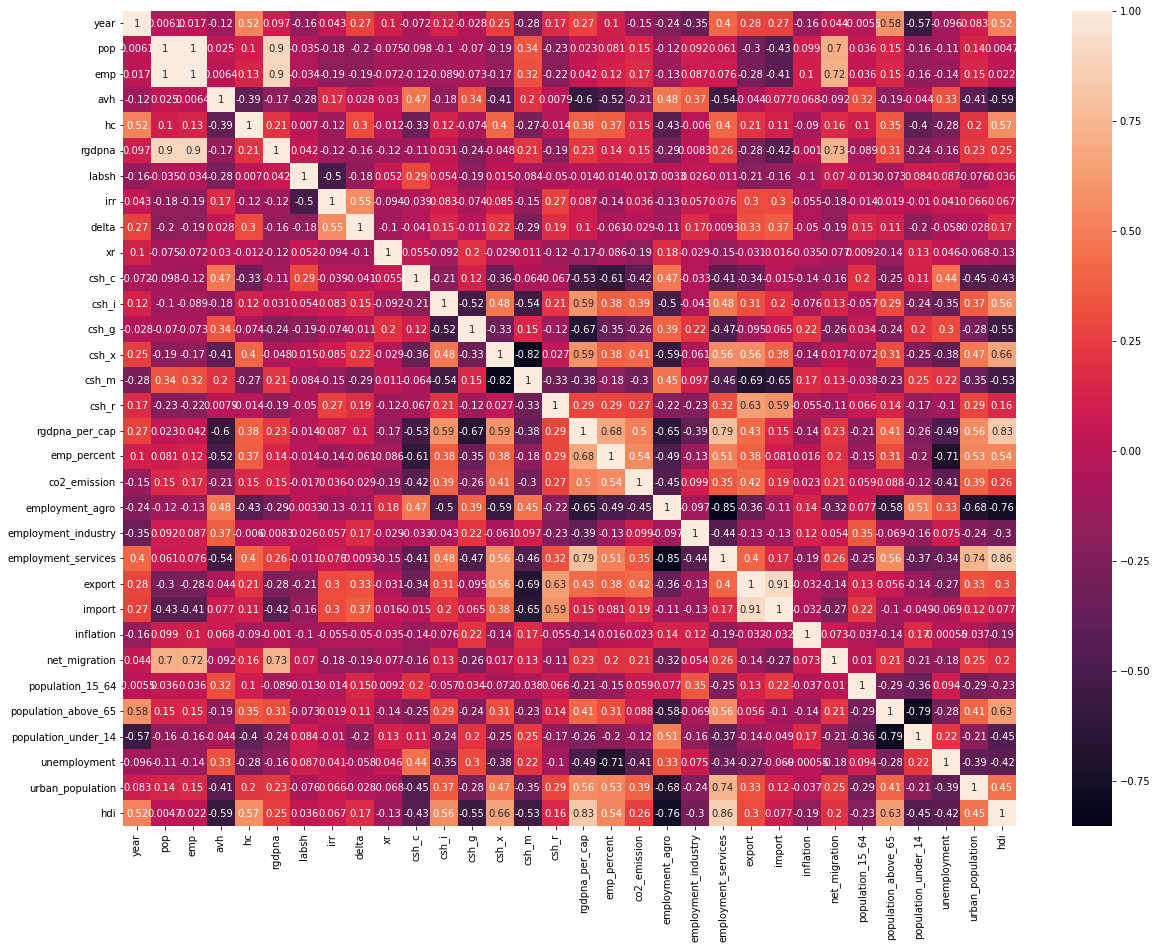

In [77]:
# Pearson's correlations
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(), annot=True)

In [78]:
data.drop('countrycode', axis=1).isna().groupby(data.countrycode, sort=False).sum().reset_index()

countrycode  country  year  pop  emp  avh  hc  rgdpna  labsh  irr  delta  \
0          ALB        1     0    1    1   31   1       1     31   31      1   
1          AUT        1     0    1    1    1   1       1      1    1      1   
2          BEL        1     0    1    1    1   1       1      1    1      1   
3          BGR        1     0    1    1    6   1       1      1    1      1   
4          BIH        1     0    1    1   31  31       1      1    1      1   
5          BLR        1     0    1    1   31  31       1      1    1      1   
6          CHE        1     0    1    1    1   1       1      1    1      1   
7          CZE        1     0    1    1    4   1       1      1    1      1   
8          DEU        1     0    1    1    1   1       1      1    1      1   
9          DNK        1     0    1    1    1   1       1      1    1      1   
10         ESP        1     0    1    1    1   1       1      1    1      1   
11         EST        1     0    1    1    6   1       1      1    1      1   
12         FIN        1     0    1    1    1   1       1      1    1      1   
13         FRA        1     0    1    1    1   1       1      1    1      1   
14         GBR        1     0    1    1    1   1       1      1    1      1   
15         GRC        1     0    1    1    1   1       1      1    1      1   
16         HRV        1     0    1    1    6   1       1      1    1      1   
17         HUN        1     0    1    1    1   1       1      1    1      1   
18         IRL        1     0    1    1    1   1       1      1    1      1   
19         ISL        1     0    1    1    1   1       1      1    1      1   
20         ITA        1     0    1    1    1   1       1      1    1      1   
21         LTU        1     0    1    1    6   1       1      1    1      1   
22         LUX        1     0    1    1    1   1       1      1    1      1   
23         LVA        1     0    1    1    6   1       1      1    1      1   
24         MDA        1     0    1    1   31   1       1      1    1      1   
25         MKD        1     0    1    1   31  31       1      1    1      1   
26         MLT        1     0    1    1    5   1       1      1    1      1   
27         MNE        1     0    1    1   31  31       1     31   31      1   
28         NLD        1     0    1    1    1   1       1      1    1      1   
29         NOR        1     0    1    1    1   1       1      1    1      1   
30         POL        1     0    1    1    6   1       1      1    1      1   
31         PRT        1     0    1    1    1   1       1      1    1      1   
32         ROU        1     0    1    1    6   1       1      1    1      1   
33         RUS        1     0    1    1    3   1       1      1    1      1   
34         SRB        1     0    1    1   31   1       1      1    1      1   
35         SVK        1     0    1    1    1   1       1      1    1      1   
36         SVN        1     0    1    1    6   1       1      1    1      1   
37         SWE        1     0    1    1    1   1       1      1    1      1   
38         UKR        1     0    1    1   31   1       1      1    1      1   
39         AND       31     0   31   31   31  31      31     31   31     31   
40         FRO       31     0   31   31   31  31      31     31   31     31   
41         GIB       31     0   31   31   31  31      31     31   31     31   
42         IMN       31     0   31   31   31  31      31     31   31     31   
43         LIE       31     0   31   31   31  31      31     31   31     31   
44         MCO       31     0   31   31   31  31      31     31   31     31   
45         SMR       31     0   31   31   31  31      31     31   31     31   

    xr  csh_c  csh_i  csh_g  csh_x  csh_m  csh_r  rgdpna_per_cap  emp_percent  \
0    1      1      1      1      1      1      1               1            1   
1    1      1      1      1      1      1      1               1            1   
2    1      1      1      1      1      1     

In [79]:
# filtering out countries with too many missing values
missing_countries = ['CYP', 'FRO', 'GIB', 'IMN', 'MCO', 'SMR', 'AND', 'LIE']
data = data[~data.countrycode.isin(missing_countries)]
data = data.drop('emp', axis=1) # replaced by emp_percent

In [80]:
# checking number of missing values for each year
data.drop('year', axis=1).isna().groupby(data.year, sort=False).sum().reset_index() 

year  countrycode  country  pop  avh  hc  rgdpna  labsh  irr  delta  xr  \
0   1990            0        0    0   19   4       0      2    2      0   0   
1   1991            0        0    0   19   4       0      2    2      0   0   
2   1992            0        0    0   18   4       0      2    2      0   0   
3   1993            0        0    0   17   4       0      2    2      0   0   
4   1994            0        0    0   16   4       0      2    2      0   0   
5   1995            0        0    0    8   4       0      2    2      0   0   
6   1996            0        0    0    8   4       0      2    2      0   0   
7   1997            0        0    0    8   4       0      2    2      0   0   
8   1998            0        0    0    8   4       0      2    2      0   0   
9   1999            0        0    0    8   4       0      2    2      0   0   
10  2000            0        0    0    8   4       0      2    2      0   0   
11  2001            0        0    0    8   4       0      2    2      0   0   
12  2002            0        0    0    8   4       0      2    2      0   0   
13  2003            0        0    0    8   4       0      2    2      0   0   
14  2004            0        0    0    8   4       0      2    2      0   0   
15  2005            0        0    0    8   4       0      2    2      0   0   
16  2006            0        0    0    8   4       0      2    2      0   0   
17  2007            0        0    0    8   4       0      2    2      0   0   
18  2008            0        0    0    8   4       0      2    2      0   0   
19  2009            0        0    0    8   4       0      2    2      0   0   
20  2010            0        0    0    8   4       0      2    2      0   0   
21  2011            0        0    0    8   4       0      2    2      0   0   
22  2012            0        0    0    8   4       0      2    2      0   0   
23  2013            0        0    0    8   4       0      2    2      0   0   
24  2014            0        0    0    8   4       0      2    2      0   0   
25  2015            0        0    0    8   4       0      2    2      0   0   
26  2016            0        0    0    8   4       0      2    2      0   0   
27  2017            0        0    0    8   4       0      2    2      0   0   
28  2018            0        0    0    8   4       0      2    2      0   0   
29  2019            0        0    0    8   4       0      2    2      0   0   
30  2020            0       39   39   39  39      39     39   39     39  39   

    csh_c  csh_i  csh_g  csh_x  csh_m  csh_r  rgdpna_per_cap  emp_percent  \
0       0      0      0      0      0      0               0            0   
1       0      0      0      0      0      0               0            0   
2       0      0      0      0      0      0               0            0   
3       0      0      0      0      0      0               0            0   
4       0      0      0      0      0      0               0            0   
5       0      0      0      0      0      0               0            0   
6       0      0      0      0      0      0               0            0   
7       0      0      0      0      0      0               0            0   
8       0      0      0      0      0      0               0            0   
9       0      0      0      0      0      0               0            0   
10      0      0      0      0      0      0               0            0   
11      0      0      0      0      0      0               0            0   
12      0      0      0      0      0      0               0            0   
13      0      0      0      0      0      0               0            0   
14      0      0      0      0      0      0               0            0   
15      0      0      0      0      0      0               0            0   
16      0      0      0      0      0      0               0            0   
17      0      0      0      0      0      0               0            0   
18      0   

In [81]:
# dropping data from 2020 - too many missing values
data = data[data.year != 2020]

In [82]:
# missing values
count_missings(data)

Column  Total  Percent
0         net_migration    936   0.8000
1                   avh    289   0.2470
2                    hc    120   0.1026
3             inflation     74   0.0632
4                 labsh     60   0.0513
5                   irr     60   0.0513
6                export     55   0.0470
7                import     55   0.0470
8                   hdi     41   0.0350
9   employment_industry     39   0.0333
10  employment_services     39   0.0333
11      employment_agro     39   0.0333
12         co2_emission     39   0.0333
13         unemployment     39   0.0333
14     population_15_64      0   0.0000
15  population_under_14      0   0.0000
16     urban_population      0   0.0000
17  population_above_65      0   0.0000
18          countrycode      0   0.0000
19          emp_percent      0   0.0000
20       rgdpna_per_cap      0   0.0000
21              country      0   0.0000
22                csh_m      0   0.0000
23                csh_x      0   0.0000
24                csh_g      0   0.0000
25                csh_i      0   0.0000
26                csh_c      0   0.0000
27                   xr      0   0.0000
28                delta      0   0.0000
29               rgdpna      0   0.0000
30                  pop      0   0.0000
31                 year      0   0.0000
32                csh_r      0   0.0000

In [83]:
# dropping variables which are missing for at least one country (for all the years)
data = data.drop(['avh', 'hc', 'labsh', 'irr'], axis=1) 

<AxesSubplot:>

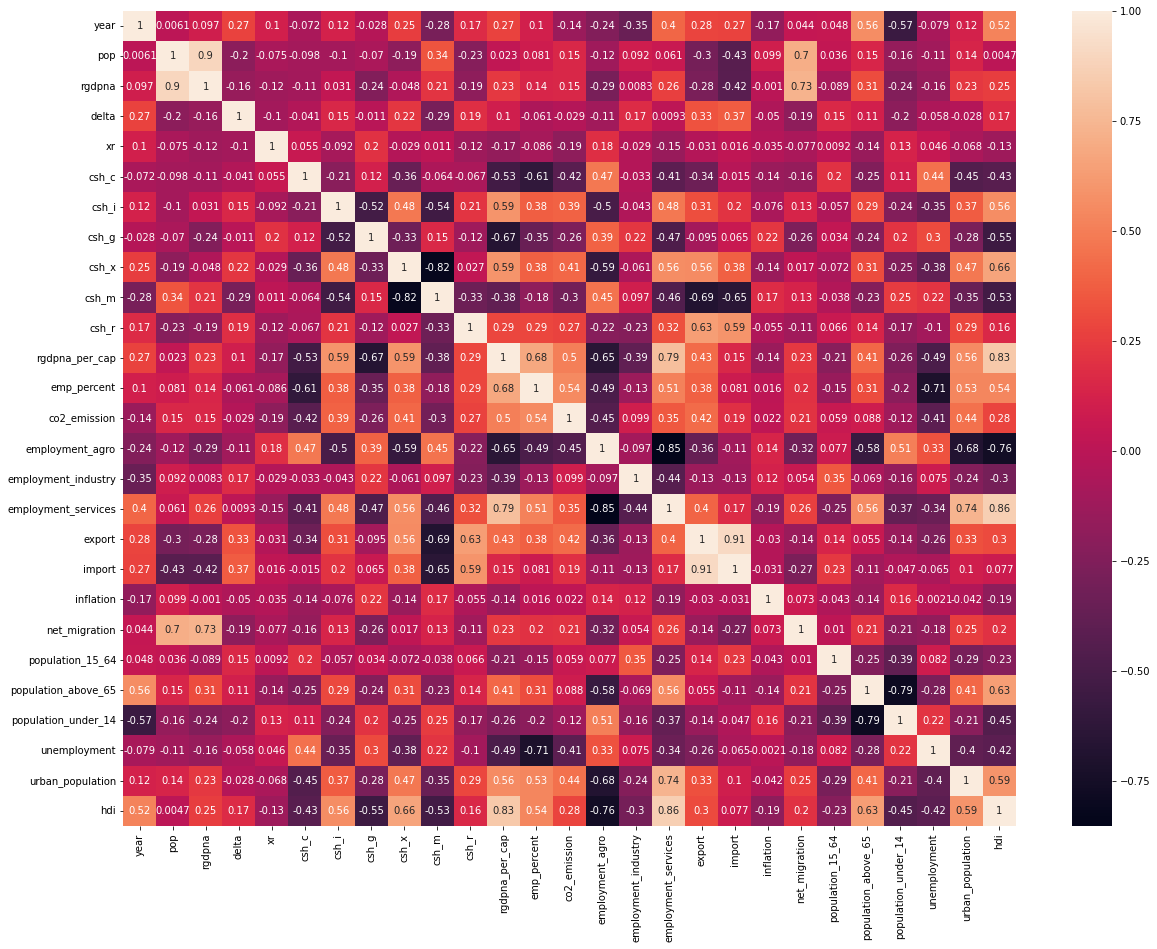

In [84]:
# Pearson's correlations
plt.figure(figsize=(20,15))
sns.heatmap(data.corr(), annot=True)

C:\Users\agama\anaconda3\envs\thesis\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


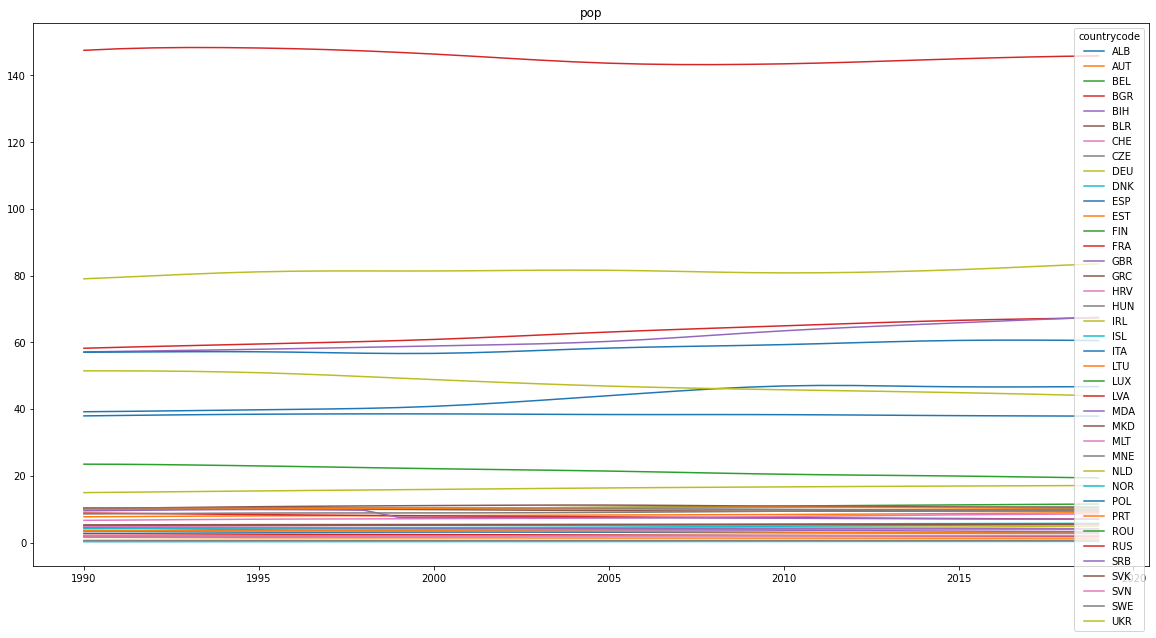

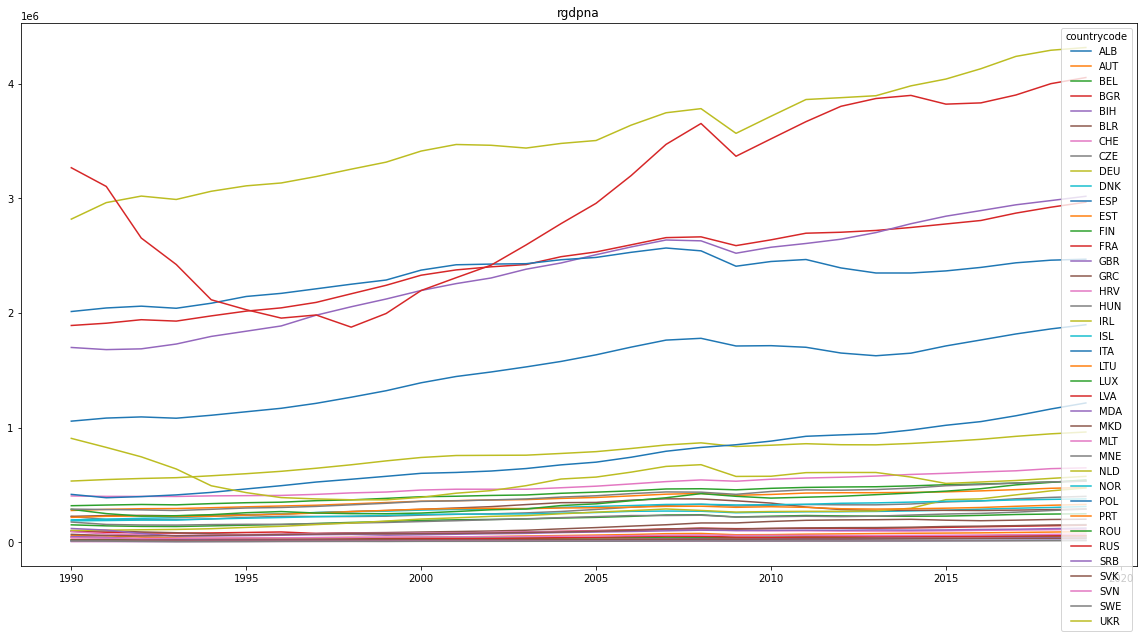

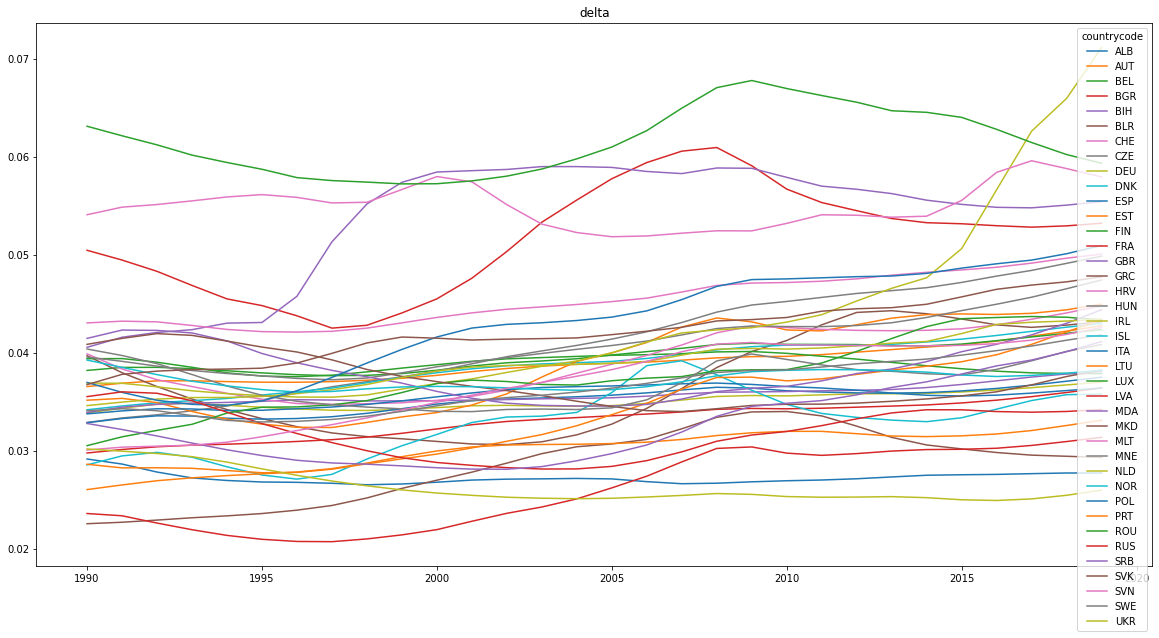

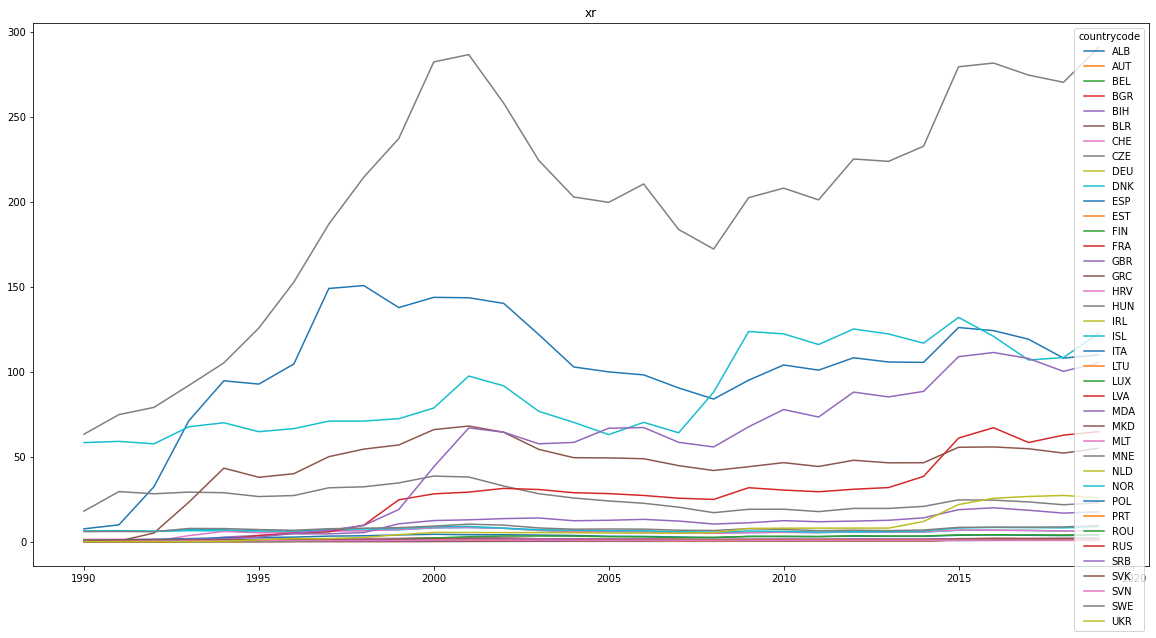

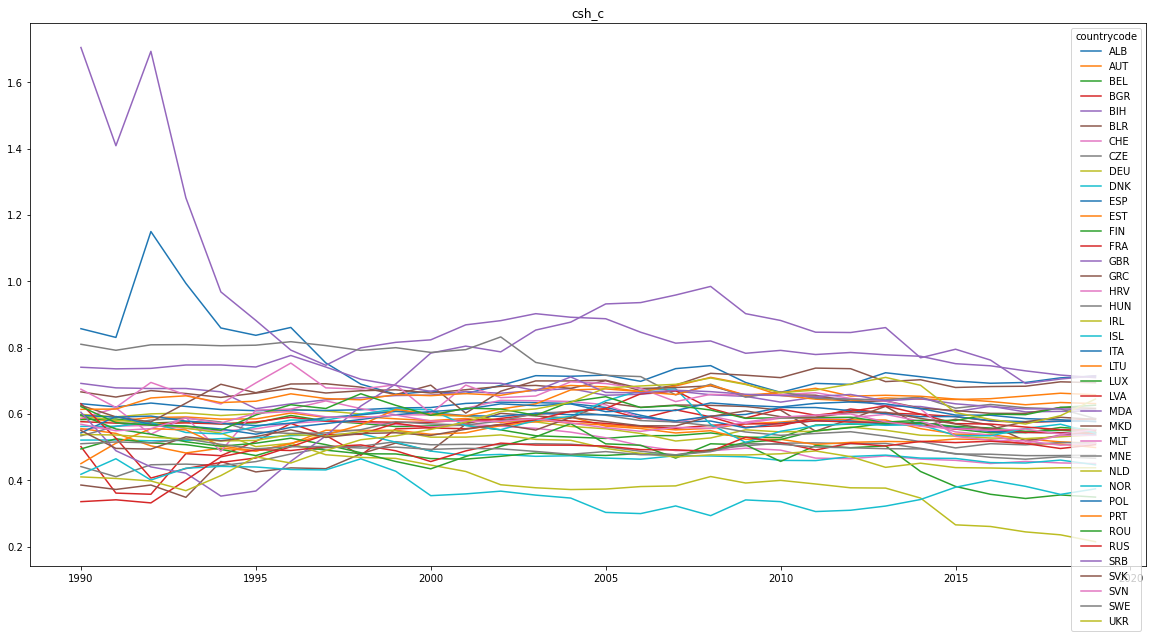

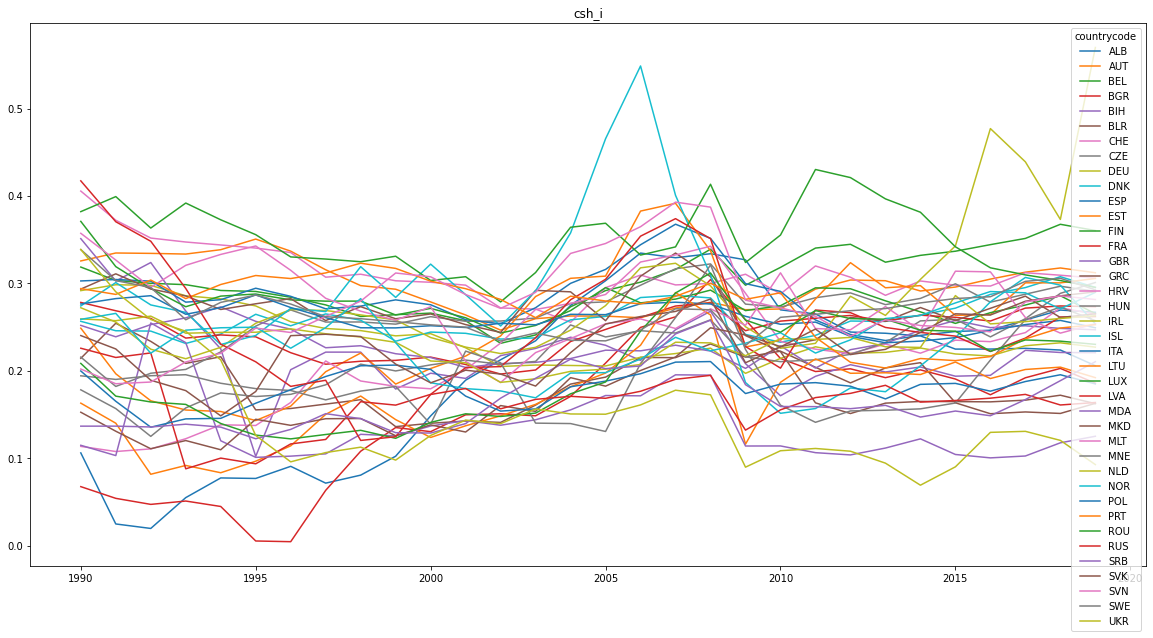

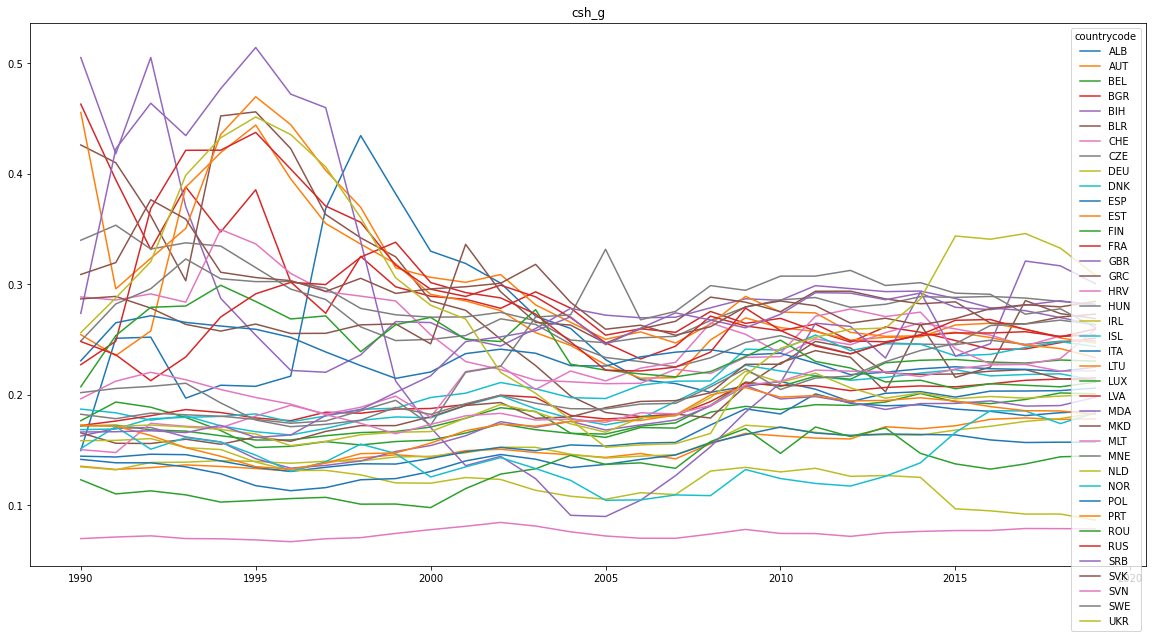

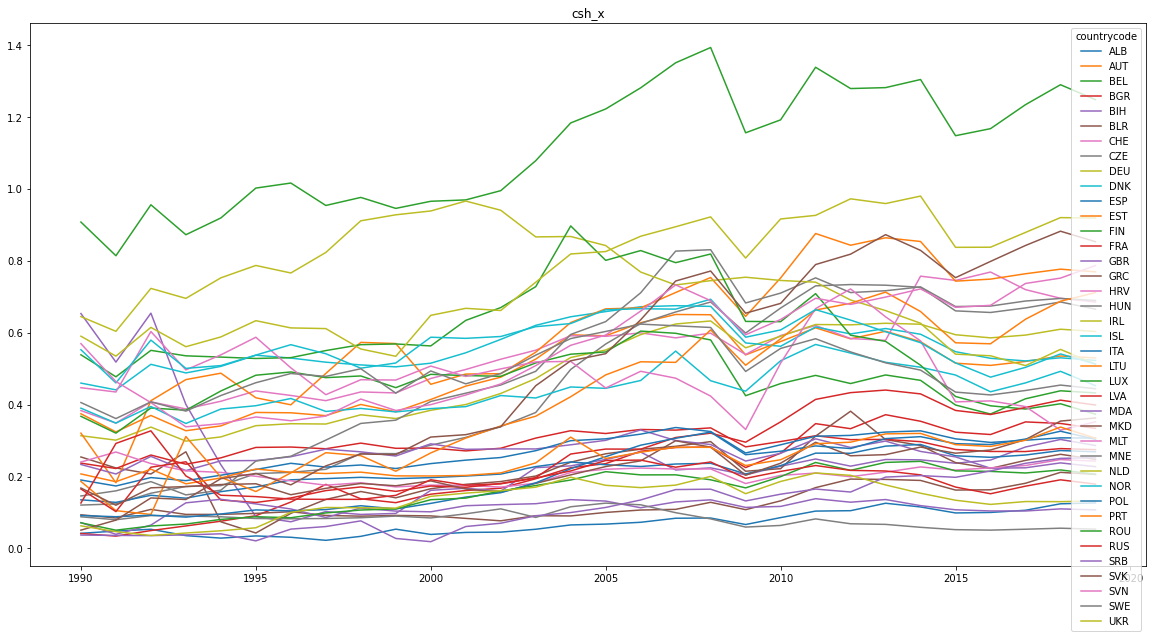

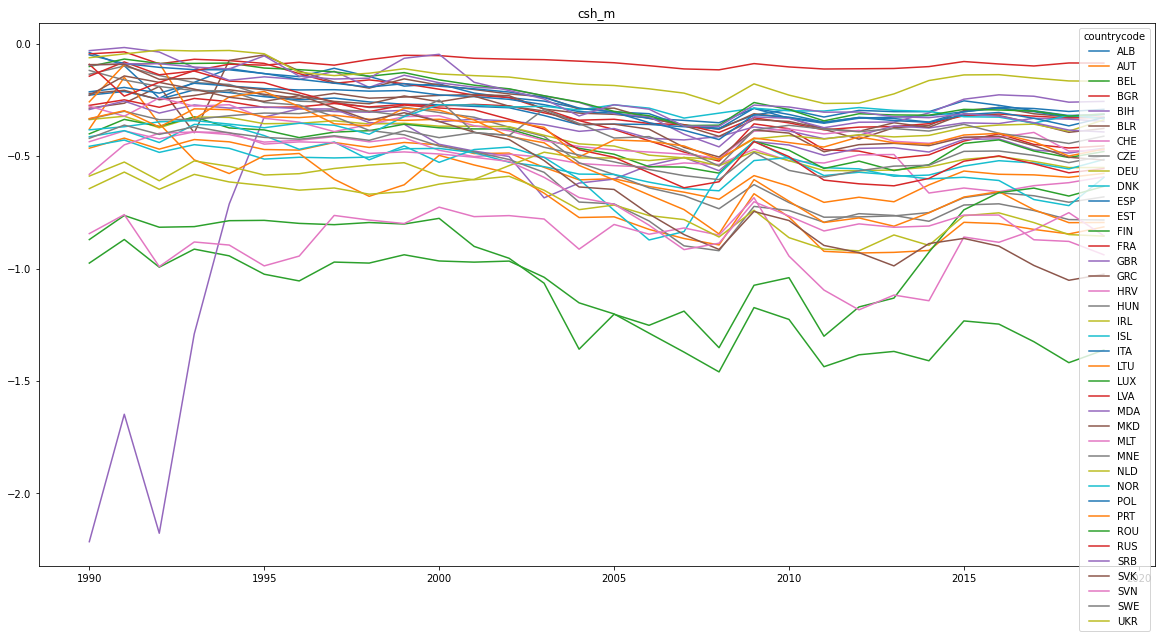

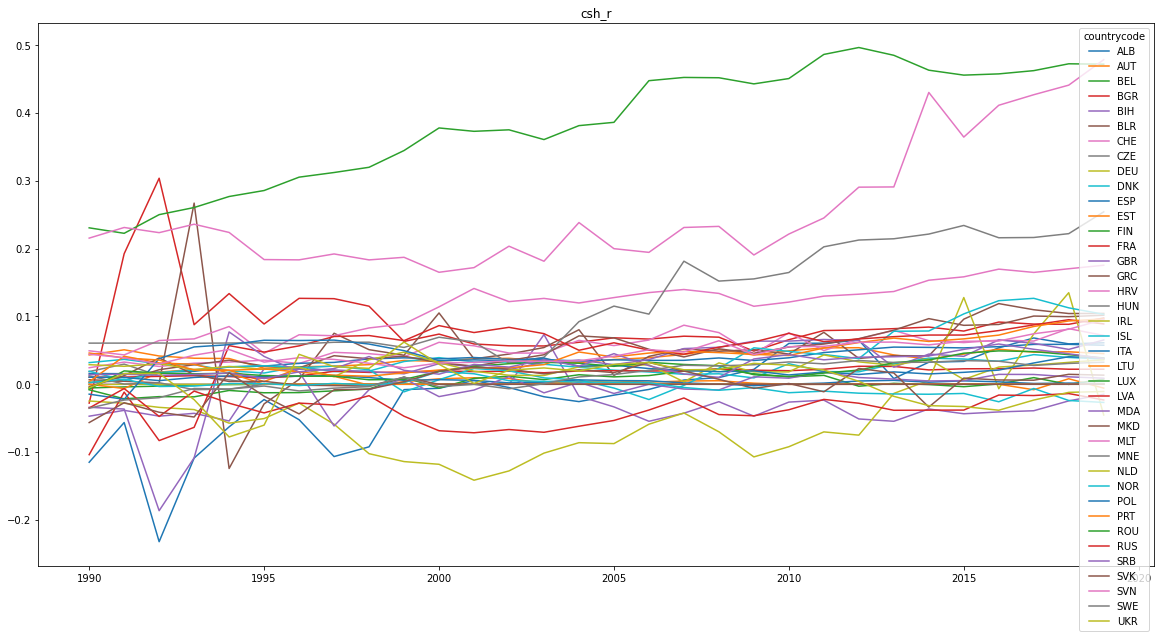

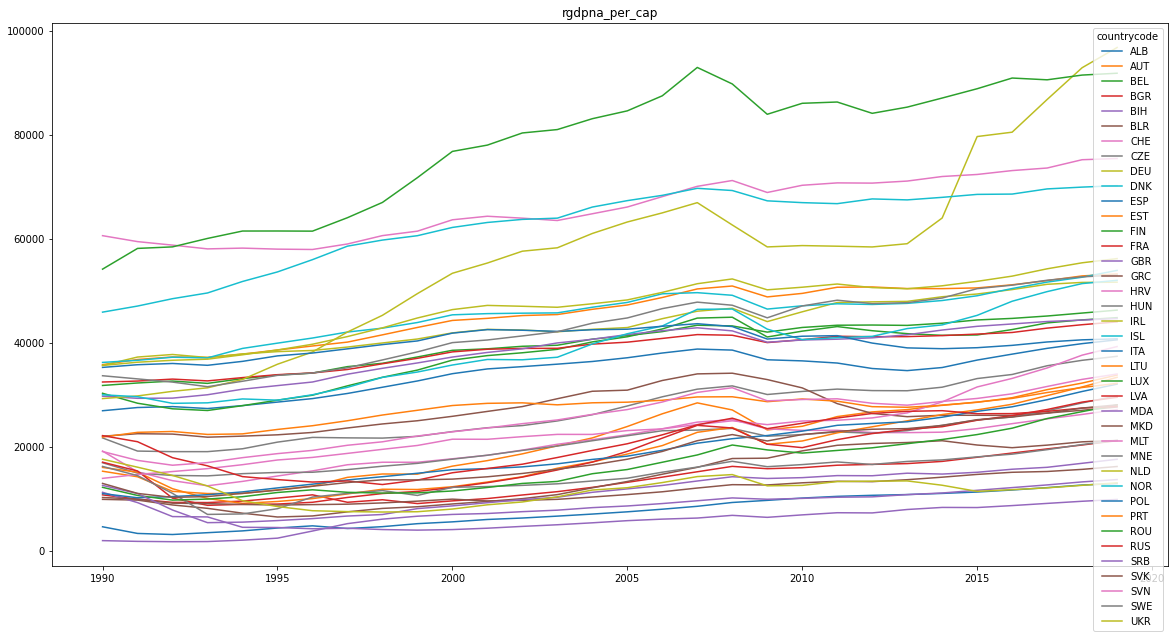

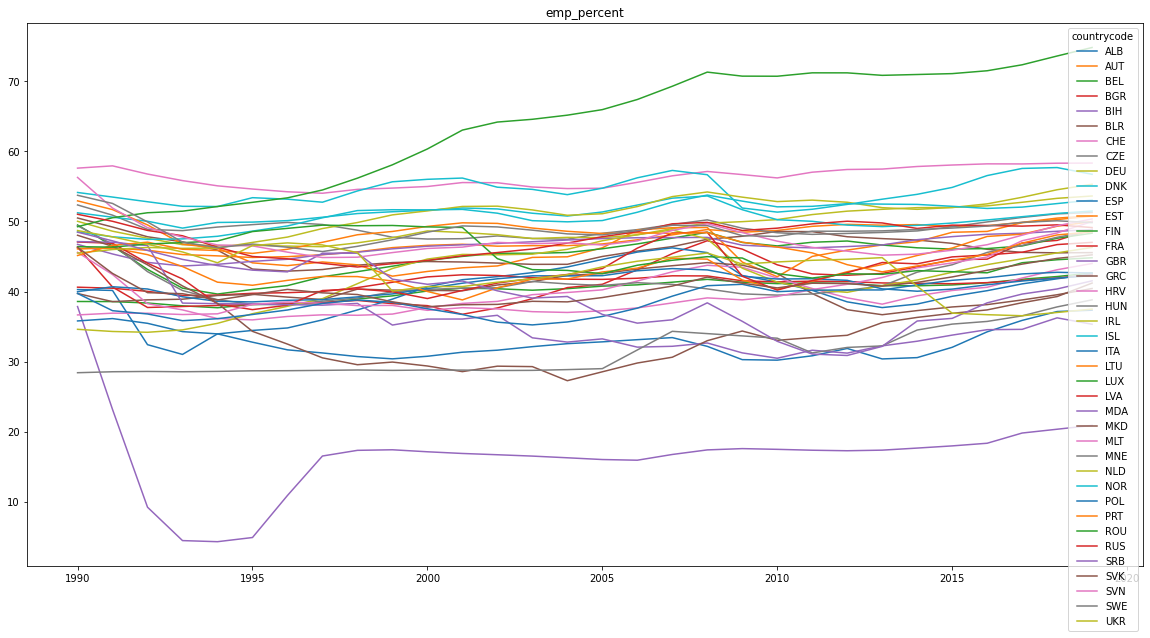

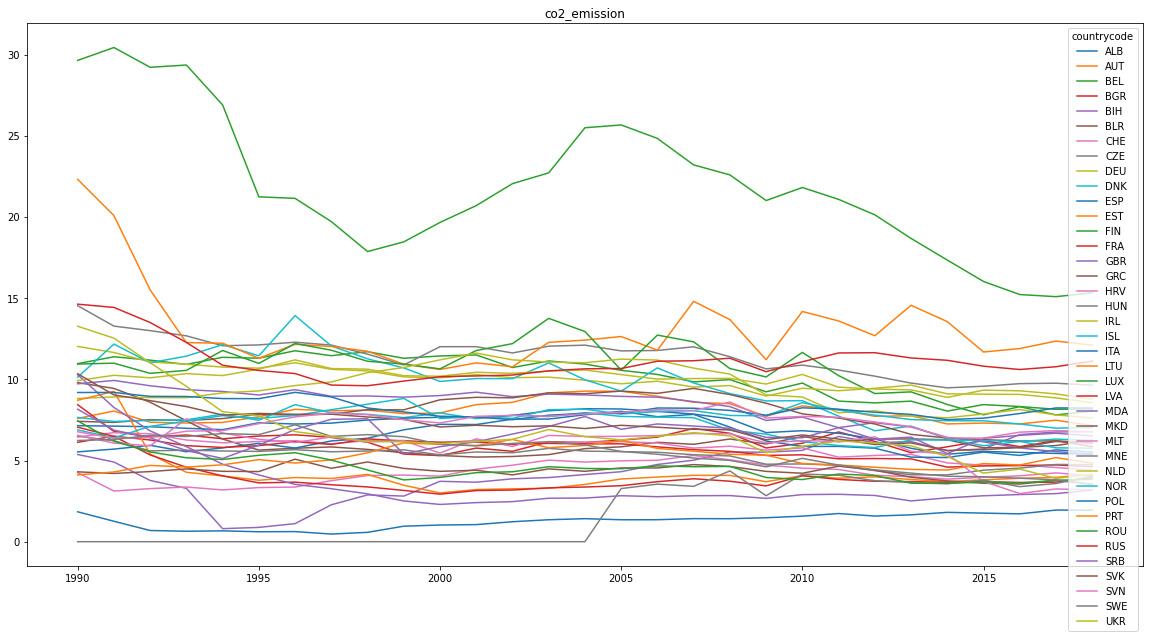

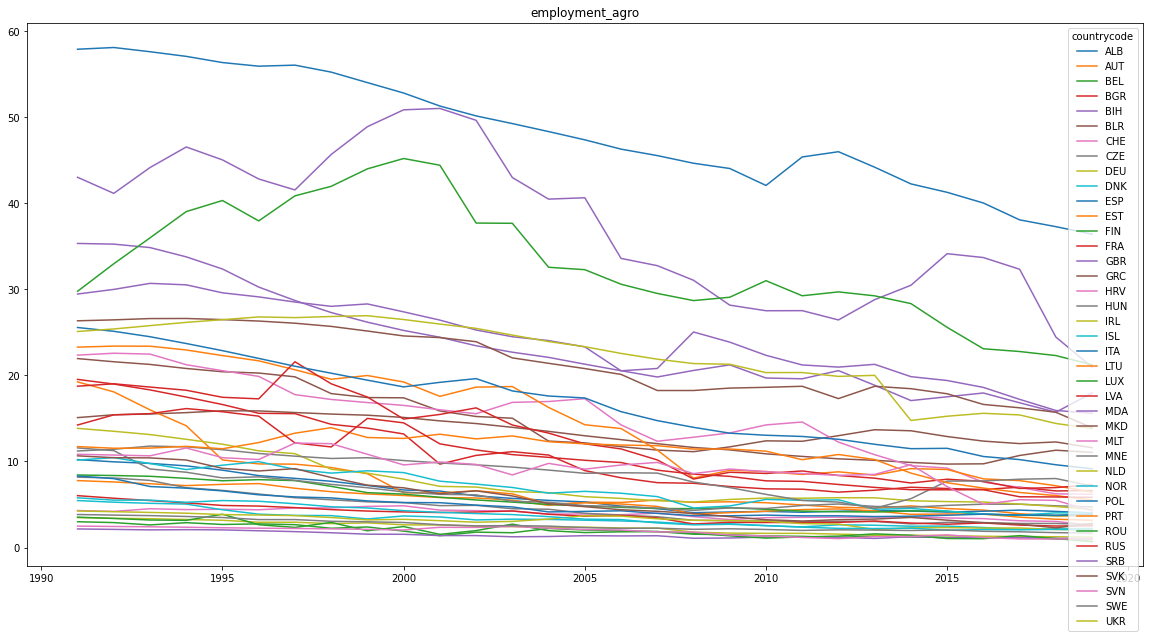

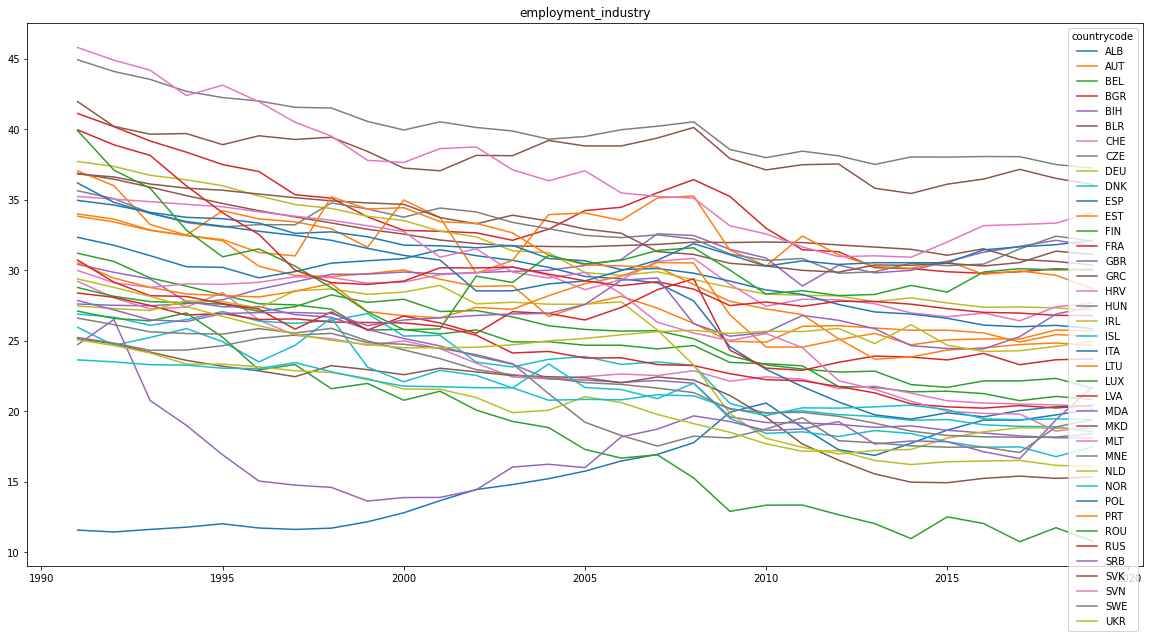

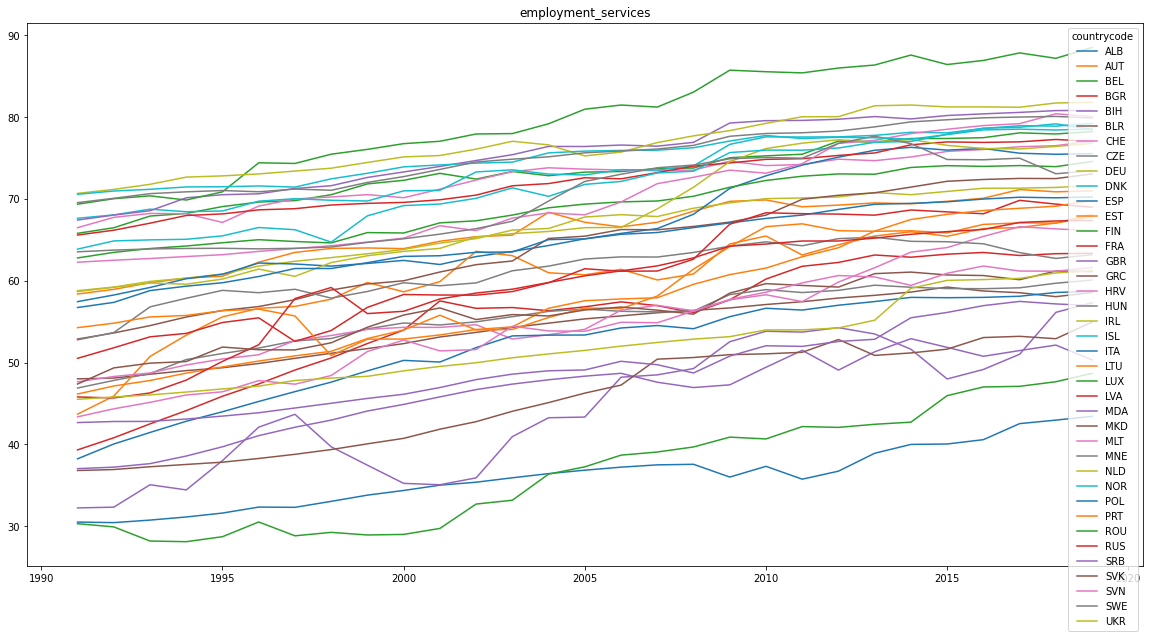

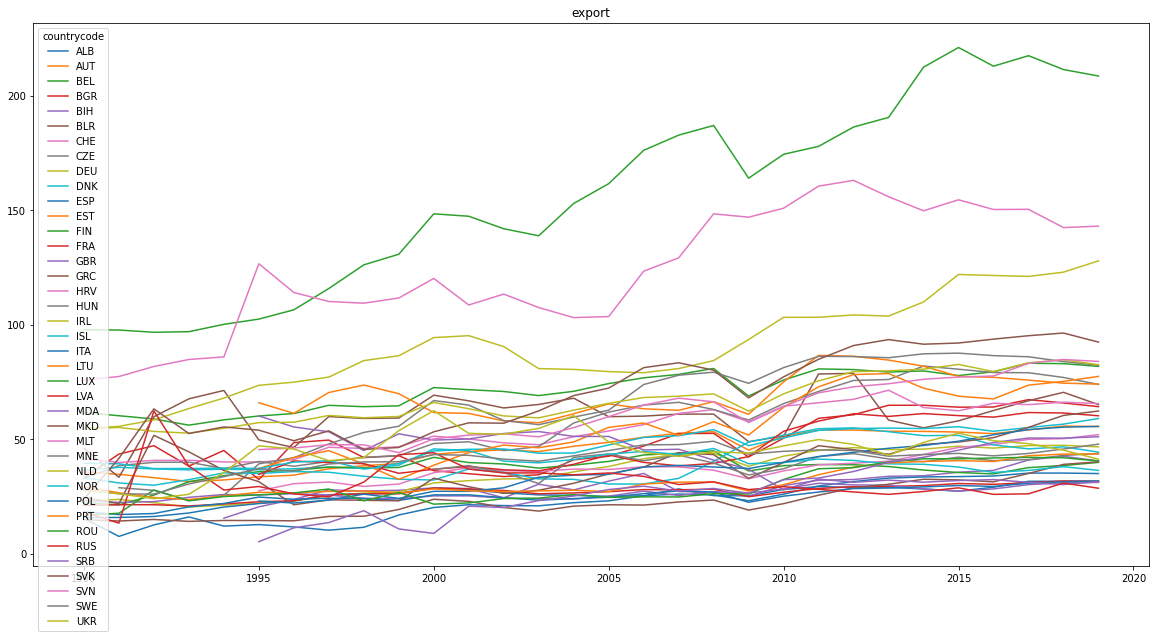

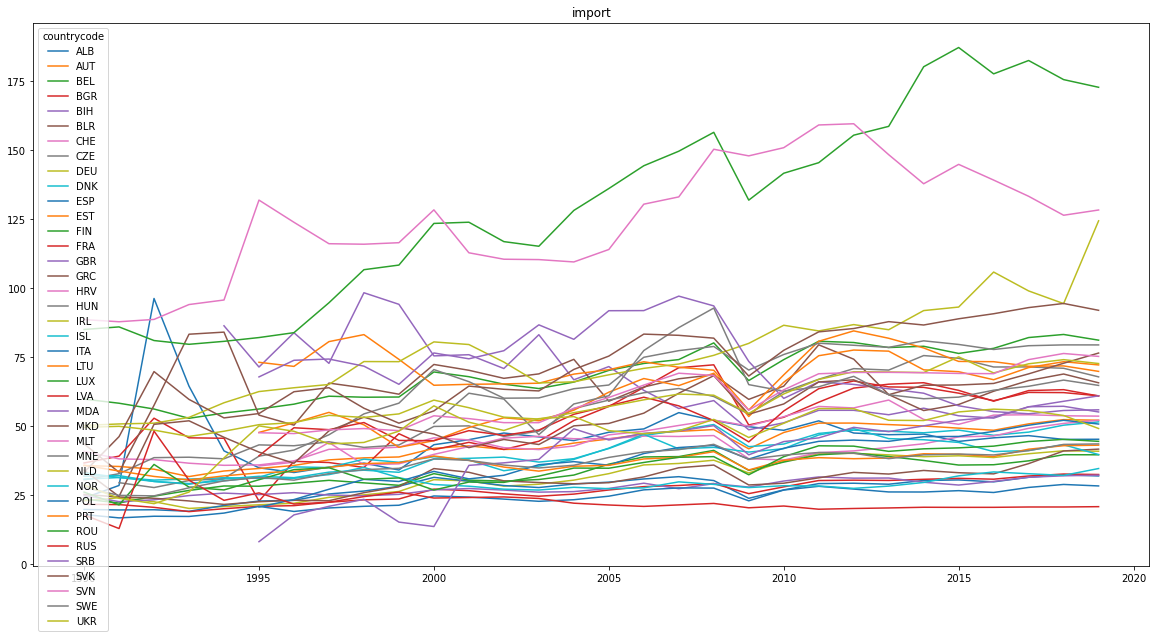

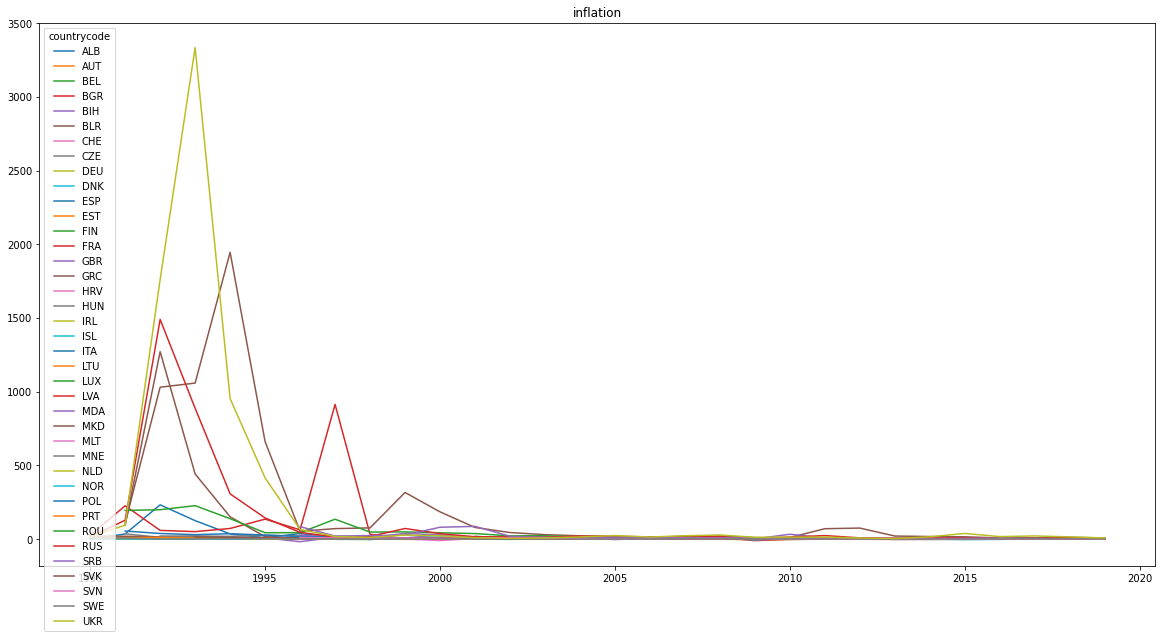

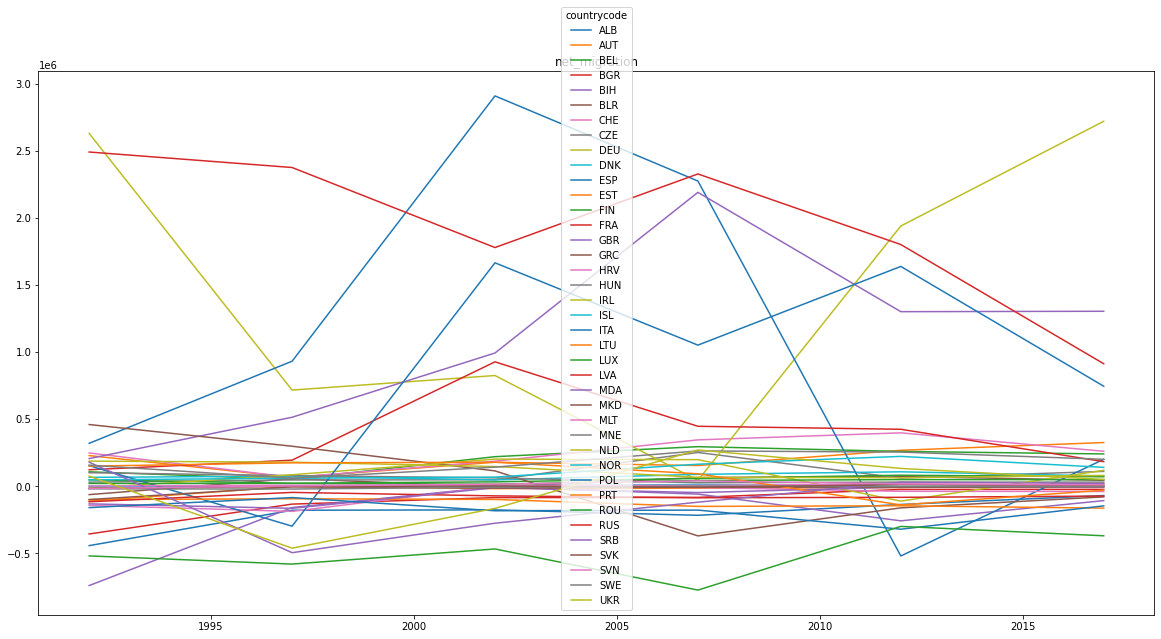

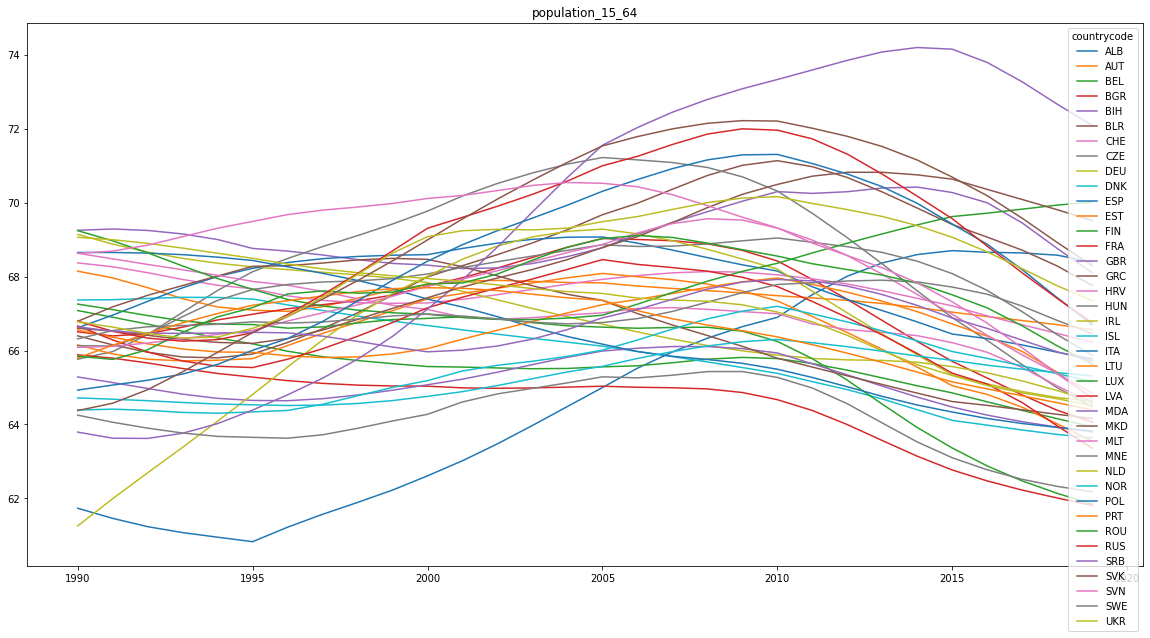

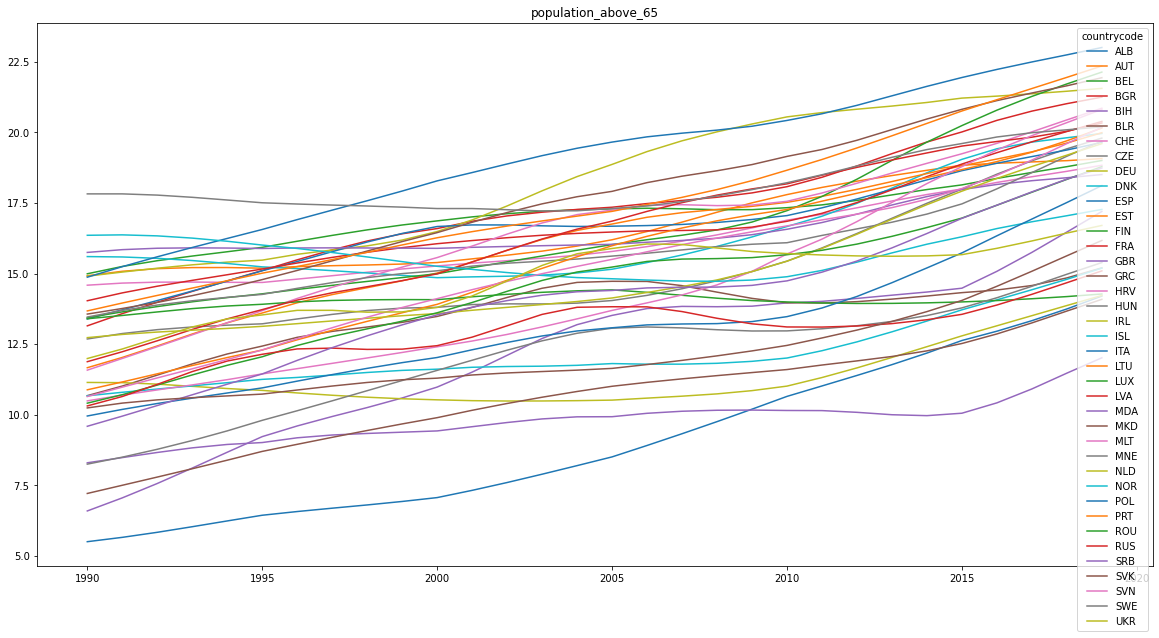

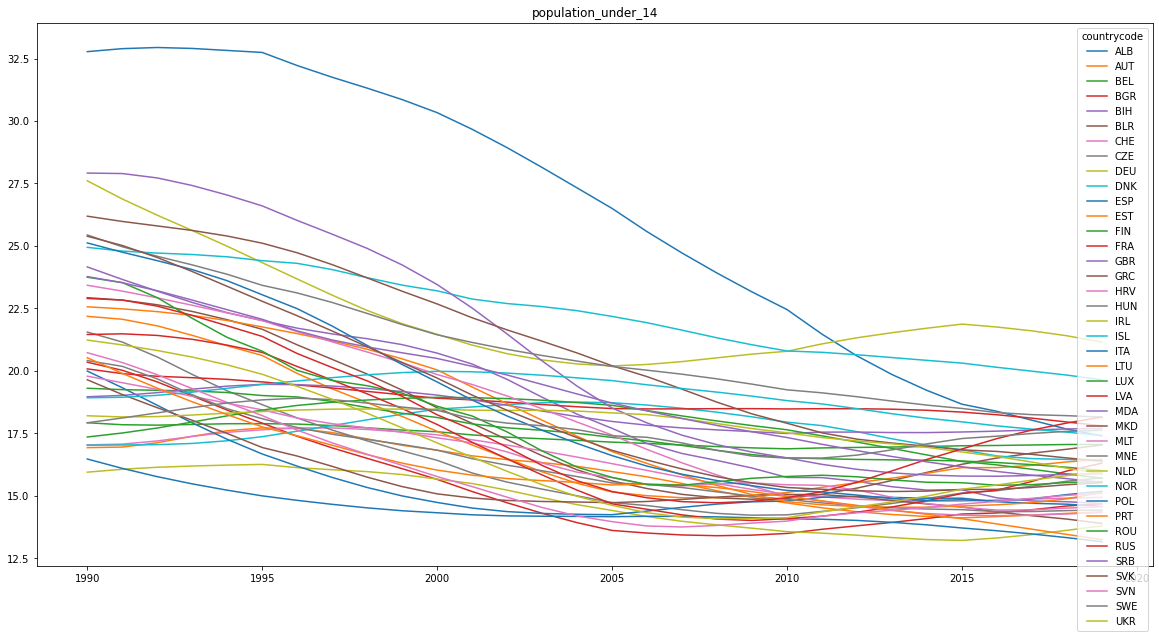

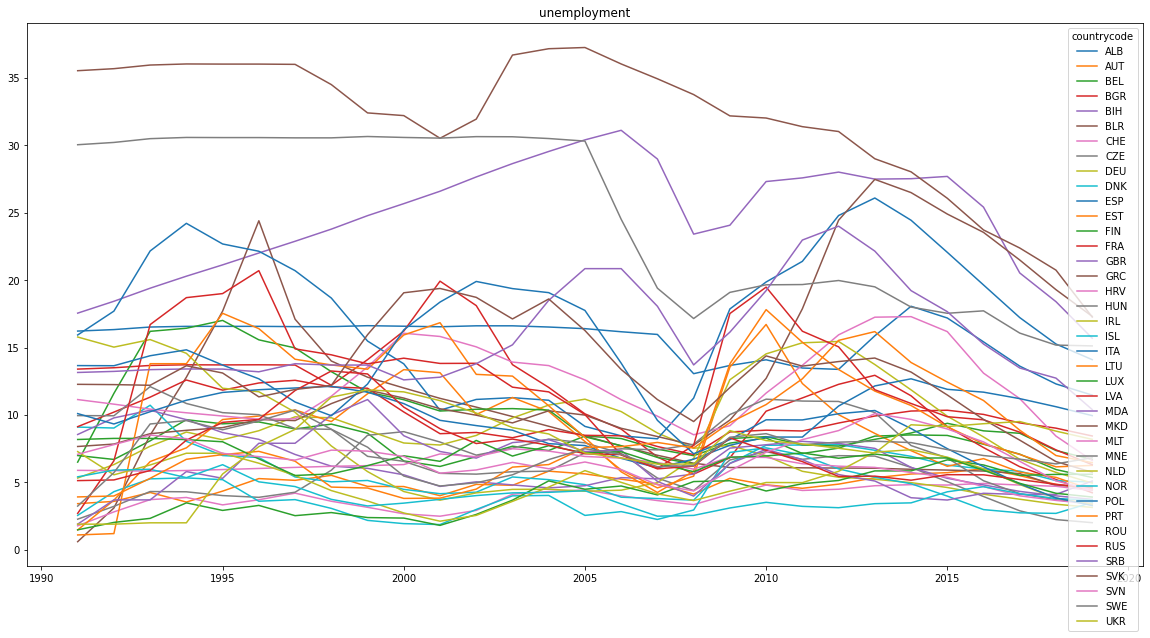

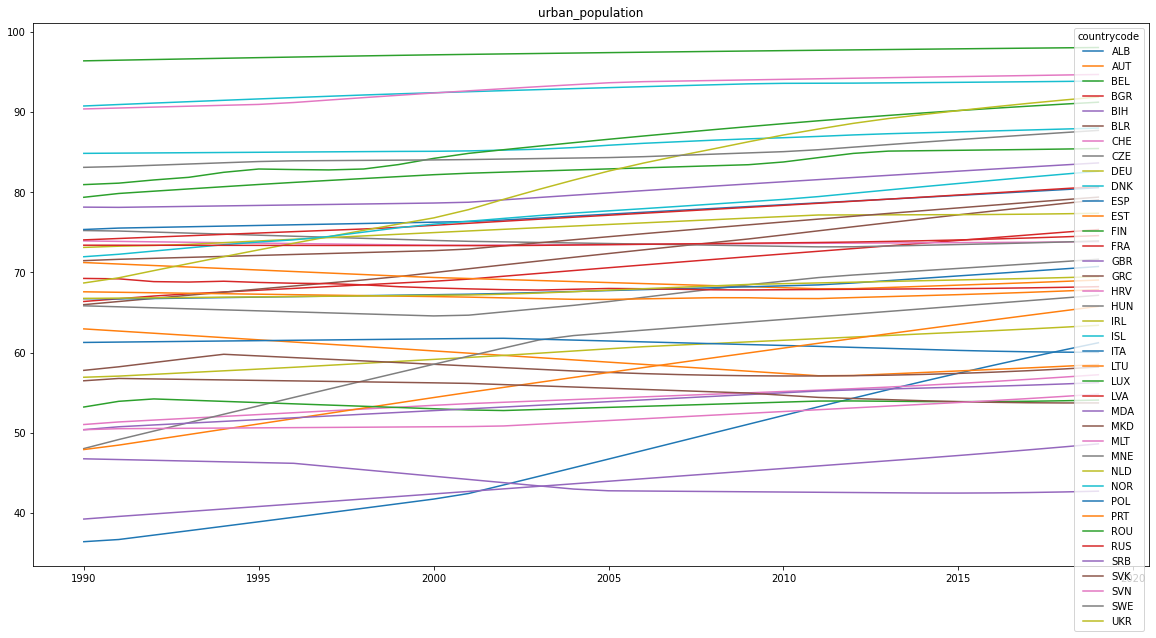

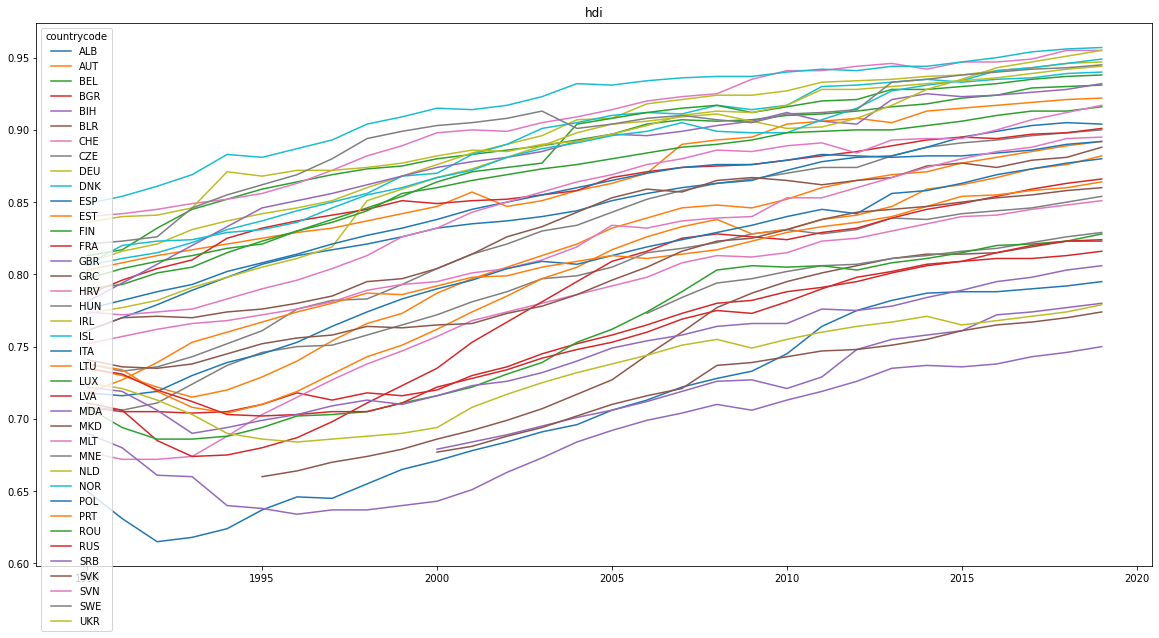

In [85]:
# plotting variables
for ind in data.columns[3:]:
    df_test = data[['countrycode','year', ind]]

    # transposing
    df_test_transposed = df_test.pivot_table(index='countrycode', columns=['year'], values=ind).reset_index()
    df_test_final = df_test_transposed.rename_axis('').rename_axis("", axis="columns").set_index('countrycode')

    df_test_final.T.plot(figsize=(20,10), title=ind)

In [86]:
# saving data 
data.to_csv('data/data_original.csv', index=False)